## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_wavelet_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\agriVision\\full\\wavelet\\red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 12760 CDFs


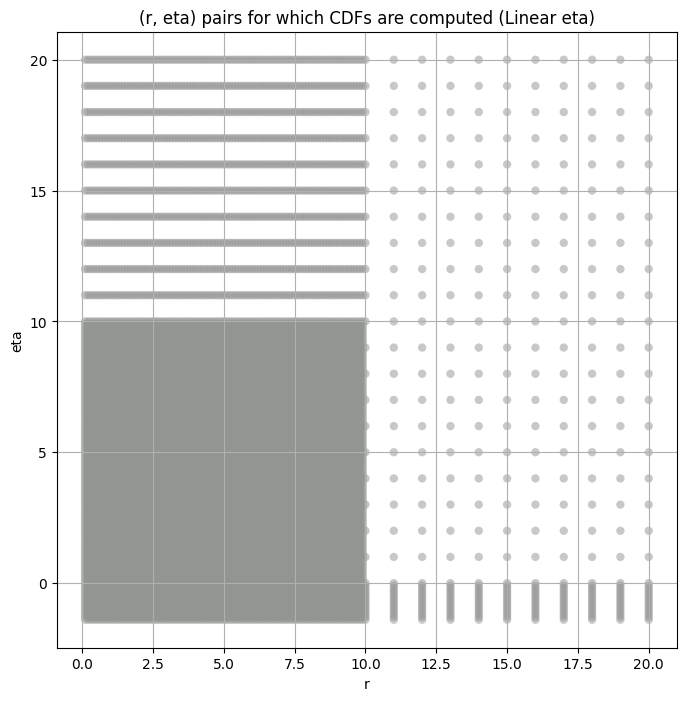

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [01:03<00:00, 1566.46it/s]


Layer 3


100%|██████████| 100000/100000 [01:08<00:00, 1457.75it/s]


Layer 4


100%|██████████| 100000/100000 [01:00<00:00, 1657.83it/s]


Layer 5


100%|██████████| 100000/100000 [00:57<00:00, 1725.77it/s]


Layer 6


100%|██████████| 100000/100000 [00:59<00:00, 1670.73it/s]


Layer 7


100%|██████████| 100000/100000 [00:59<00:00, 1675.20it/s]


Layer 8


100%|██████████| 100000/100000 [00:55<00:00, 1815.42it/s]


Layer 9


100%|██████████| 100000/100000 [00:58<00:00, 1702.84it/s]


Layer 10


100%|██████████| 100000/100000 [00:59<00:00, 1671.11it/s]


obs_var      var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                         
2      179850.660000  104860.610000  313803.400000    501.38205   36.681150   
3       48278.000000   29689.330000   75753.010000    352.49054   90.264786   
4       13505.898000    6427.192000   29259.107000   1066.34280  112.379980   
5        3324.956000    1098.146100   15512.162000   6607.17720   86.604630   
6         902.737550     217.958720    6909.141600  18939.14300   76.743290   
7         249.888720      58.955738    1795.422700  19071.88700   51.215460   
8          57.432180      22.249529     277.407500   8527.04700   61.023670   
9          14.412285       5.902647      62.396603   6442.50830   77.116610   
10          2.162876       0.811485       9.683873   7078.99500   80.460810   

       kurt_upper  total_samples  
layer                             
2        756.9423         9000.0  
3        561.8886        36000.0  
4       2700.4614       144000.0  
5       7123.8887       576000.0  
6       8727.6420      2304000.0  
7       8606.3420      9216000.0  
8       6916.6597     36864000.0  
9       6425.3364    147456000.0  
10      6695.1540    589824000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      179850.660000  179850.656250    74067.335938    64210.242188   
3       48278.000000   48278.000000    24035.449219    19635.382812   
4       13505.898000   13505.898438     6691.355469     5463.557617   
5        3324.956000    3324.956055     1151.629150      984.337280   
6         902.737550     902.737549      228.016281      195.520554   
7         249.888720     249.888718       61.201111       54.041145   
8          57.432180      57.432178       23.217001       20.164005   
9          14.412285      14.412285        6.166647        5.230673   
10          2.162876       2.162876        0.852571        0.721281   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        57748.683594     52651.171875     44625.593750     38720.957031   
3        17825.394531     16572.769531     14752.112305     13399.075195   
4         4914.768066      4542.634766      4026.576904      3661.814209   
5          881.448730       806.017334       703.294861       634.335999   
6          176.659866       163.697983       146.237167       134.353912   
7           49.992580        47.161087        43.217403        40.453289   
8           18.465260        17.349731        15.911529        14.964413   
9            4.735323         4.421290         4.021964         3.760220   
10           0.651351         0.606105         0.547652         0.508802   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         34185.144531     30431.927734     27312.673828     20459.316406  
3         12318.041992     11442.916016     10709.807617      9000.939453  
4          3397.178467      3187.020996      3012.707520      2606.340820  
5           583.981201       545.062317       513.391968       444.258209  
6           125.501007       118.509567       112.747429        99.979401  
7            38.341450        36.638653        35.215389        31.984253  
8            14.259048        13.696005        13.225320        12.140507  
9             3.565404         3.410339         3.281315         2.986739  
10            0.479912         0.456841         0.437699         0.394542

####
Layer  2


100%|██████████| 12760/12760 [00:10<00:00, 1250.90it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.01657267583225619 179850.66


100%|██████████| 12760/12760 [00:09<00:00, 1304.65it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.011226391220584109 74067.336


100%|██████████| 12760/12760 [00:09<00:00, 1414.18it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.012668656745345674 64210.242


100%|██████████| 12760/12760 [00:08<00:00, 1458.97it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.014862942059235884 57748.684


100%|██████████| 12760/12760 [00:09<00:00, 1330.13it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.01726723475669356 52651.17


100%|██████████| 12760/12760 [00:09<00:00, 1377.75it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.02325478529383429 44625.594


100%|██████████| 12760/12760 [00:09<00:00, 1391.86it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.028657158646555603 38720.957


100%|██████████| 12760/12760 [00:09<00:00, 1405.62it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.033406777529977116 34185.145


100%|██████████| 12760/12760 [00:09<00:00, 1363.61it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.03769787170415728 30431.928


100%|██████████| 12760/12760 [00:09<00:00, 1309.11it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.04361774650217276 27312.674


100%|██████████| 12760/12760 [00:09<00:00, 1287.98it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.059251400542214824 20459.316
Number of samples: 9000, Without approximation : 9000.0


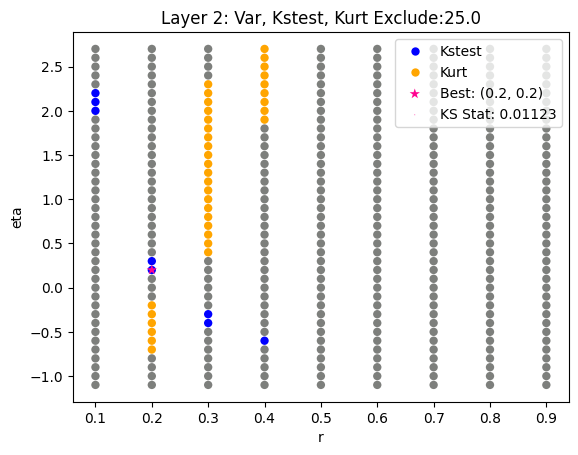

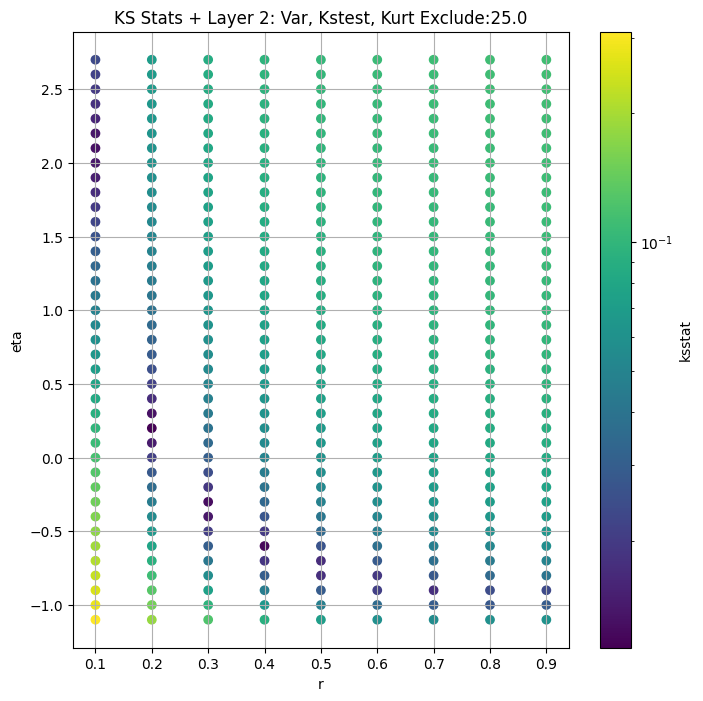

####
Layer  3


100%|██████████| 12760/12760 [00:38<00:00, 334.82it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.02350395947110323 48278.0


100%|██████████| 12760/12760 [00:38<00:00, 335.05it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.014169474962582473 24035.45


100%|██████████| 12760/12760 [00:38<00:00, 332.89it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.011348031388023316 19635.383


100%|██████████| 12760/12760 [00:37<00:00, 341.20it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.011557499667909088 17825.395


100%|██████████| 12760/12760 [00:36<00:00, 345.42it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.010956634553882127 16572.77


100%|██████████| 12760/12760 [00:35<00:00, 355.88it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.010554533423327683 14752.112


100%|██████████| 12760/12760 [00:38<00:00, 335.03it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.012229436875302035 13399.075


100%|██████████| 12760/12760 [00:38<00:00, 328.52it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.012340288080725847 12318.042


100%|██████████| 12760/12760 [00:38<00:00, 335.32it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.013913368619183186 11442.916


100%|██████████| 12760/12760 [00:37<00:00, 341.36it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.015545526667350318 10709.808


100%|██████████| 12760/12760 [00:38<00:00, 330.71it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.01906138336878005 9000.939
Number of samples: 36000, Without approximation : 36000.0


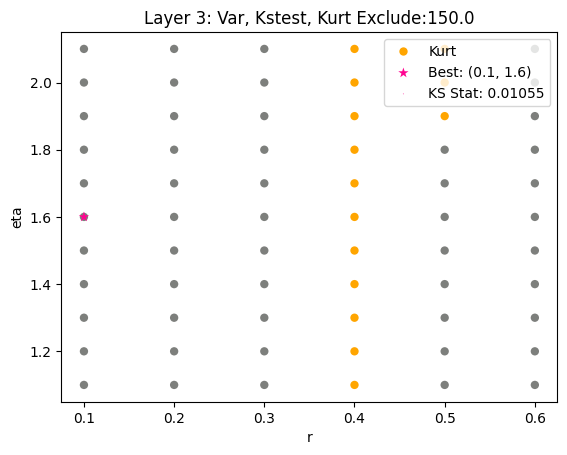

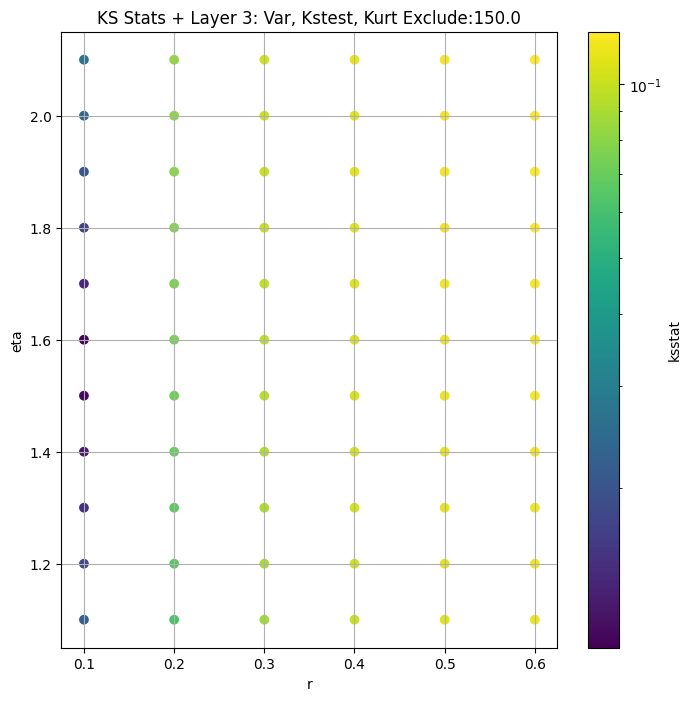

####
Layer  4


100%|██████████| 12760/12760 [01:48<00:00, 117.92it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.031201025716502295 13505.898


100%|██████████| 12760/12760 [01:51<00:00, 114.70it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.020784430567933485 6691.3555


100%|██████████| 12760/12760 [01:52<00:00, 113.58it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.01786421163237656 5463.5576


100%|██████████| 12760/12760 [01:54<00:00, 111.72it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.015627828892226997 4914.768


100%|██████████| 12760/12760 [01:52<00:00, 113.85it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.014688691209007843 4542.635


100%|██████████| 12760/12760 [01:51<00:00, 114.11it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.010852384737759874 4026.577


100%|██████████| 12760/12760 [01:46<00:00, 120.33it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.00958953655233652 3661.8142


100%|██████████| 12760/12760 [01:50<00:00, 115.89it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.00870740791599367 3397.1785


100%|██████████| 12760/12760 [01:49<00:00, 117.01it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.0076086424479113735 3187.021


100%|██████████| 12760/12760 [01:48<00:00, 117.46it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.0068319376310044255 3012.7075


100%|██████████| 12760/12760 [01:48<00:00, 117.93it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.008213776150539004 2606.3408
Number of samples: 100000, Without approximation : 144000.0


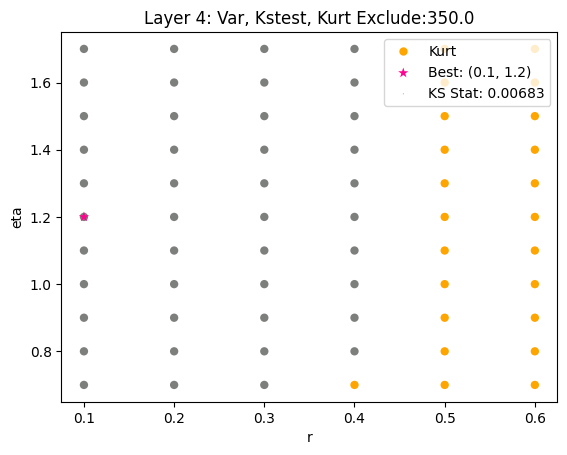

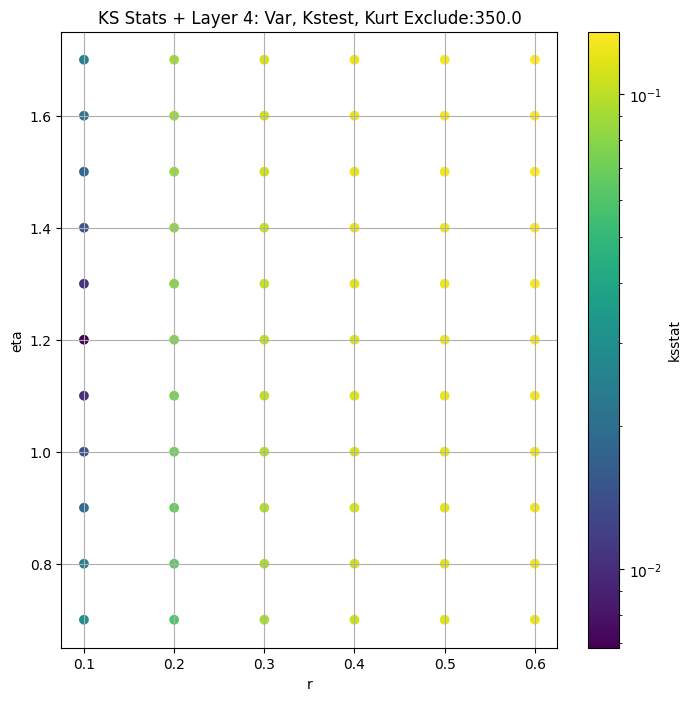

####
Layer  5


100%|██████████| 12760/12760 [01:47<00:00, 118.40it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.03965484822152454 3324.956


100%|██████████| 12760/12760 [01:48<00:00, 117.70it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.02136601080666245 1151.6292


100%|██████████| 12760/12760 [01:52<00:00, 113.40it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.016779776596969873 984.3373


100%|██████████| 12760/12760 [01:50<00:00, 115.75it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.0161260069765905 881.4487


100%|██████████| 12760/12760 [01:48<00:00, 117.45it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.014490610537530368 806.01733


100%|██████████| 12760/12760 [01:49<00:00, 116.14it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.01151713833443302 703.29486


100%|██████████| 12760/12760 [01:52<00:00, 113.89it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.0095416515868747 634.336


100%|██████████| 12760/12760 [01:51<00:00, 114.57it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.006939614807198152 583.9812


100%|██████████| 12760/12760 [01:50<00:00, 115.29it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.006518790045062728 545.0623


100%|██████████| 12760/12760 [01:49<00:00, 116.46it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.006038651345006585 513.39197


100%|██████████| 12760/12760 [01:53<00:00, 112.02it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.007773958120236402 444.2582
Number of samples: 100000, Without approximation : 576000.0


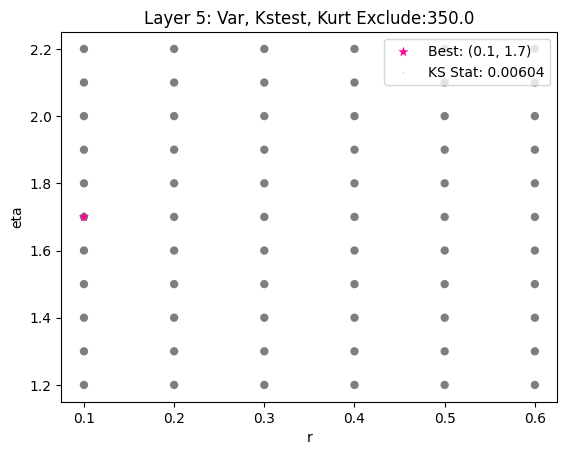

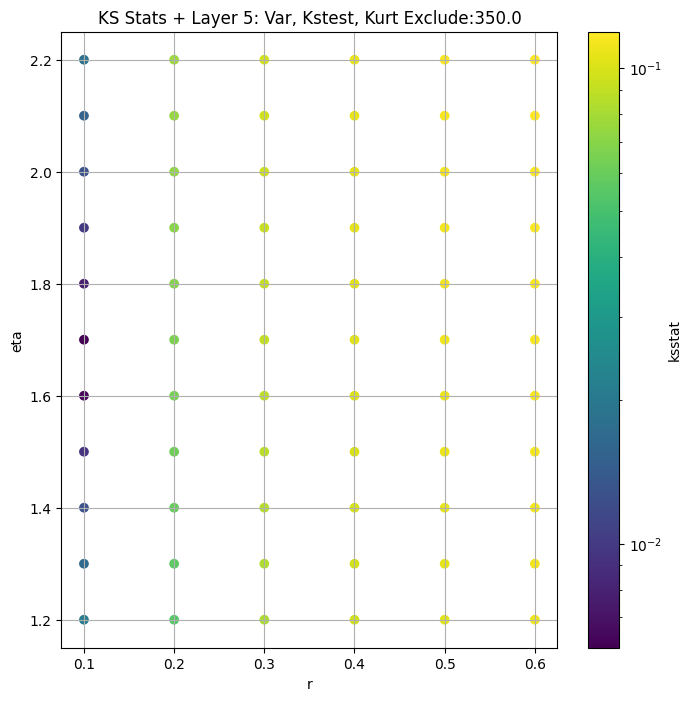

####
Layer  6


100%|██████████| 12760/12760 [01:49<00:00, 116.29it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.04206545670748573 902.73755


100%|██████████| 12760/12760 [01:51<00:00, 114.31it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.016523895454224516 228.01628


100%|██████████| 12760/12760 [01:45<00:00, 120.40it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.012696113069886161 195.52055


100%|██████████| 12760/12760 [01:44<00:00, 122.44it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.010514078539429261 176.65987


100%|██████████| 12760/12760 [01:42<00:00, 124.35it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.008421027891084787 163.69798


100%|██████████| 12760/12760 [01:44<00:00, 121.53it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.005981558697326 146.23717


100%|██████████| 12760/12760 [01:43<00:00, 123.88it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.0044316945127395035 134.35391


100%|██████████| 12760/12760 [01:45<00:00, 121.12it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.0039034461095115436 125.50101


100%|██████████| 12760/12760 [01:44<00:00, 122.30it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.004504966504212282 118.50957


100%|██████████| 12760/12760 [01:44<00:00, 121.99it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.005072194679364261 112.74743


100%|██████████| 12760/12760 [01:45<00:00, 121.05it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.0068403067126484585 99.9794
Number of samples: 100000, Without approximation : 2304000.0


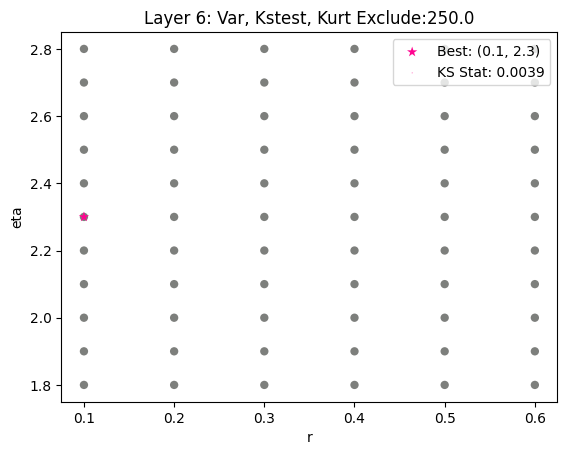

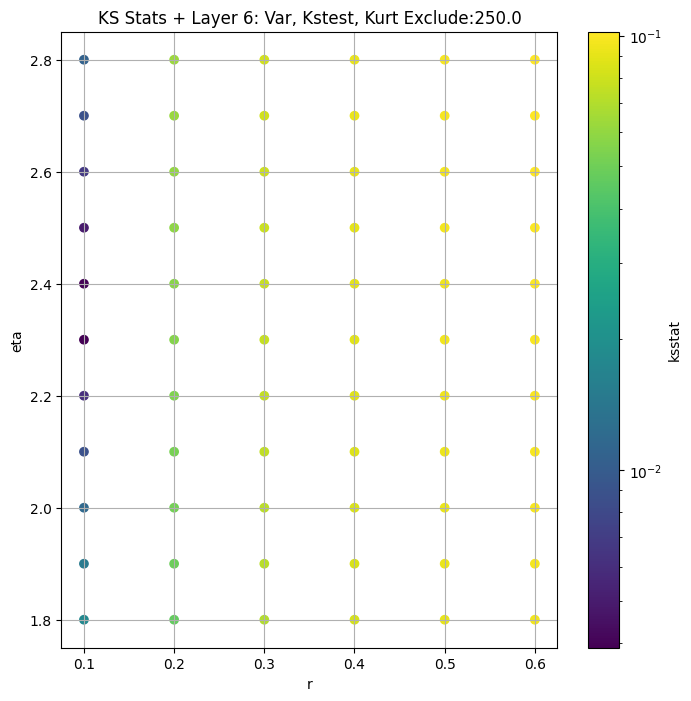

####
Layer  7


100%|██████████| 12760/12760 [01:42<00:00, 124.02it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.03820499288937235 249.88872


100%|██████████| 12760/12760 [01:49<00:00, 117.02it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.01140619636307083 61.20111


100%|██████████| 12760/12760 [01:49<00:00, 116.43it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.008108793561052763 54.041145


100%|██████████| 12760/12760 [01:49<00:00, 116.77it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.005819206330633375 49.99258


100%|██████████| 12760/12760 [01:48<00:00, 117.19it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.004451031557199392 47.161087


100%|██████████| 12760/12760 [01:50<00:00, 115.34it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.0029100000000000237 43.217403


100%|██████████| 12760/12760 [01:49<00:00, 116.74it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.003009882750732662 40.45329


100%|██████████| 12760/12760 [01:48<00:00, 117.94it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.0036278112260954565 38.34145


100%|██████████| 12760/12760 [01:48<00:00, 117.89it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.004288861637591346 36.638653


100%|██████████| 12760/12760 [01:49<00:00, 116.32it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.005017572051479013 35.21539


100%|██████████| 12760/12760 [01:50<00:00, 115.82it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.006859740358865052 31.984253
Number of samples: 100000, Without approximation : 9216000.0


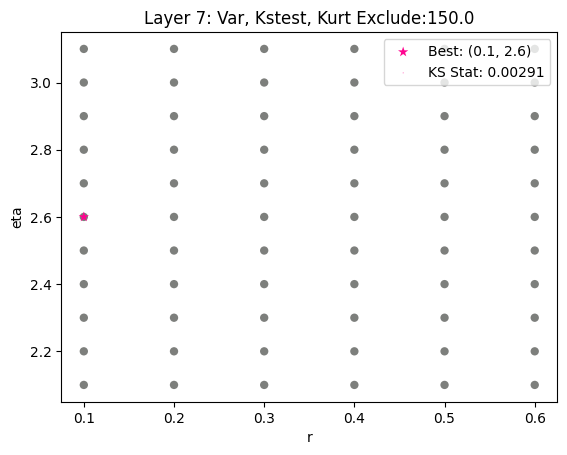

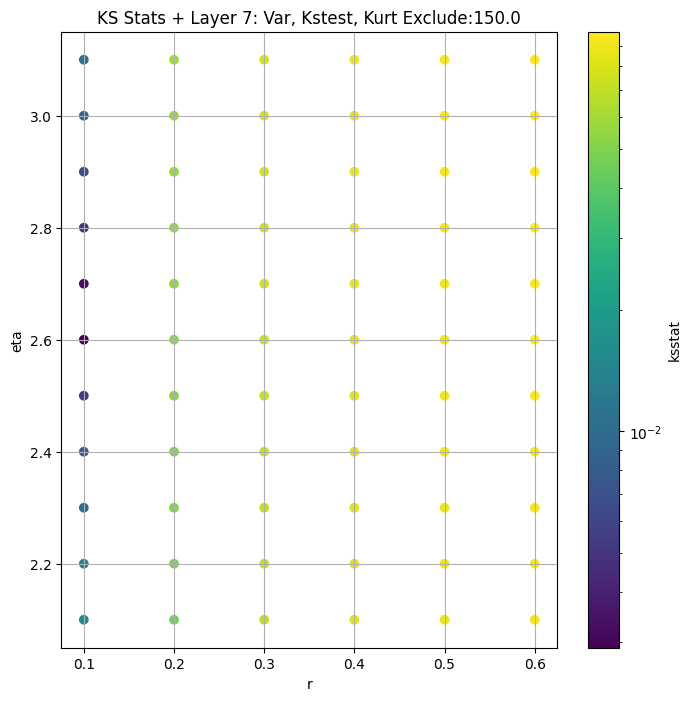

####
Layer  8


100%|██████████| 12760/12760 [01:47<00:00, 119.06it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.028640252913504693 57.43218


100%|██████████| 12760/12760 [01:50<00:00, 115.76it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.009223472017059753 23.217001


100%|██████████| 12760/12760 [01:56<00:00, 109.58it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.005015802896684907 20.164005


100%|██████████| 12760/12760 [01:58<00:00, 107.66it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.003380000000000105 18.46526


100%|██████████| 12760/12760 [01:56<00:00, 109.91it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.003380000000000105 17.349731


100%|██████████| 12760/12760 [02:03<00:00, 103.48it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.003379999999996608 15.911529


100%|██████████| 12760/12760 [01:59<00:00, 107.08it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.003379999999996497 14.964413


100%|██████████| 12760/12760 [01:59<00:00, 106.34it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.003624427506387584 14.2590475


100%|██████████| 12760/12760 [01:58<00:00, 107.82it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.0045030309673808055 13.696005


100%|██████████| 12760/12760 [01:59<00:00, 107.05it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.00517585900409645 13.22532


100%|██████████| 12760/12760 [01:56<00:00, 109.34it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007063840504020091 12.140507
Number of samples: 100000, Without approximation : 36864000.0


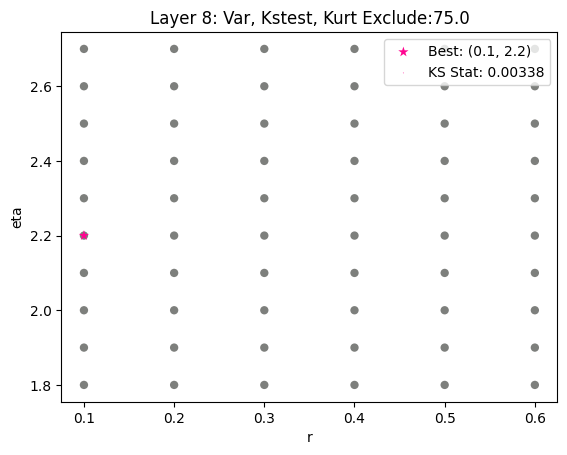

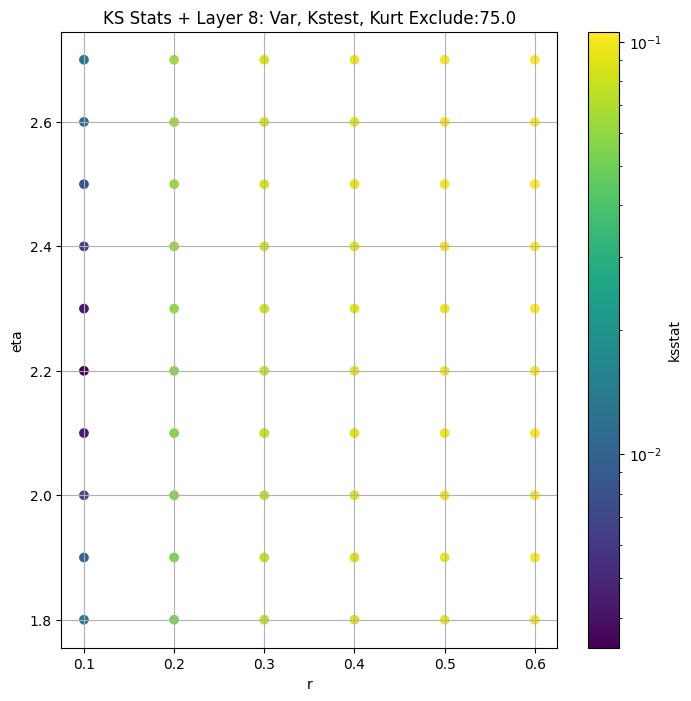

####
Layer  9


100%|██████████| 12760/12760 [02:02<00:00, 104.47it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.029802073018858677 14.412285


100%|██████████| 12760/12760 [02:02<00:00, 104.34it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.011667230354874825 6.166647


100%|██████████| 12760/12760 [02:01<00:00, 104.89it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.008514299963601202 5.230673


100%|██████████| 12760/12760 [01:57<00:00, 109.03it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.006400564678700316 4.7353234


100%|██████████| 12760/12760 [01:54<00:00, 111.41it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.005909999999999971 4.42129


100%|██████████| 12760/12760 [02:00<00:00, 105.97it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.005909999999997195 4.0219636


100%|██████████| 12760/12760 [02:02<00:00, 104.52it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.005909999999997306 3.7602196


100%|██████████| 12760/12760 [01:56<00:00, 109.88it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.005909999999997195 3.5654042


100%|██████████| 12760/12760 [01:59<00:00, 107.04it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.005909999999997084 3.4103386


100%|██████████| 12760/12760 [01:51<00:00, 114.04it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.005909999999997306 3.2813146


100%|██████████| 12760/12760 [01:49<00:00, 116.15it/s]


Finding Minimum after computing 12760 CDFs
9 500 0.007263397020744956 2.9867387
Number of samples: 100000, Without approximation : 147456000.0


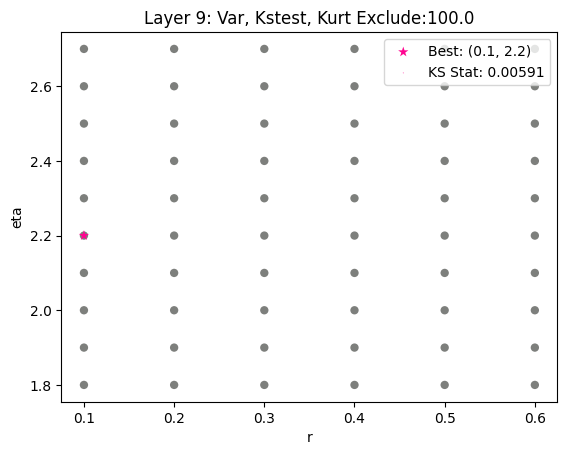

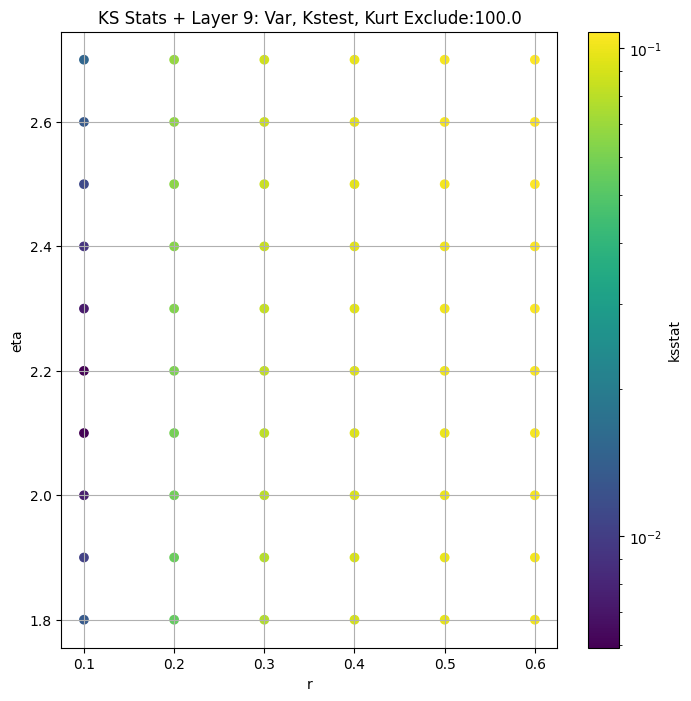

####
Layer  10


100%|██████████| 12760/12760 [01:48<00:00, 117.14it/s]


Finding Minimum after computing 12760 CDFs
10 0 0.03486745378979983 2.1628764


100%|██████████| 12760/12760 [01:51<00:00, 114.76it/s]


Finding Minimum after computing 12760 CDFs
10 25 0.02680999999999334 0.85257107


100%|██████████| 12760/12760 [01:50<00:00, 115.07it/s]


Finding Minimum after computing 12760 CDFs
10 50 0.026809999999993173 0.7212808


100%|██████████| 12760/12760 [01:49<00:00, 116.68it/s]


Finding Minimum after computing 12760 CDFs
10 75 0.02680999999999134 0.6513507


100%|██████████| 12760/12760 [01:49<00:00, 117.04it/s]


Finding Minimum after computing 12760 CDFs
10 100 0.02680999999999234 0.6061051


100%|██████████| 12760/12760 [01:48<00:00, 117.36it/s]


Finding Minimum after computing 12760 CDFs
10 150 0.026809999999988454 0.5476521


100%|██████████| 12760/12760 [01:50<00:00, 115.33it/s]


Finding Minimum after computing 12760 CDFs
10 200 0.0268099999999889 0.50880206


100%|██████████| 12760/12760 [01:52<00:00, 113.71it/s]


Finding Minimum after computing 12760 CDFs
10 250 0.02680999999998912 0.4799124


100%|██████████| 12760/12760 [01:49<00:00, 116.41it/s]


Finding Minimum after computing 12760 CDFs
10 300 0.026809999999988787 0.45684105


100%|██████████| 12760/12760 [01:50<00:00, 115.18it/s]


Finding Minimum after computing 12760 CDFs
10 350 0.02680999999998901 0.43769866


100%|██████████| 12760/12760 [01:50<00:00, 115.51it/s]


Finding Minimum after computing 12760 CDFs
10 500 0.026809999999988843 0.3945415
Number of samples: 100000, Without approximation : 589824000.0


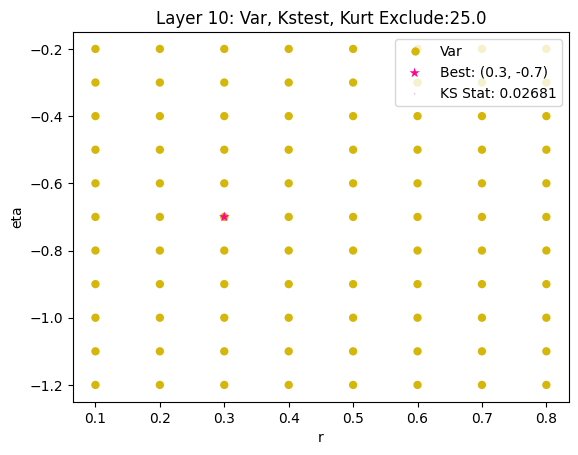

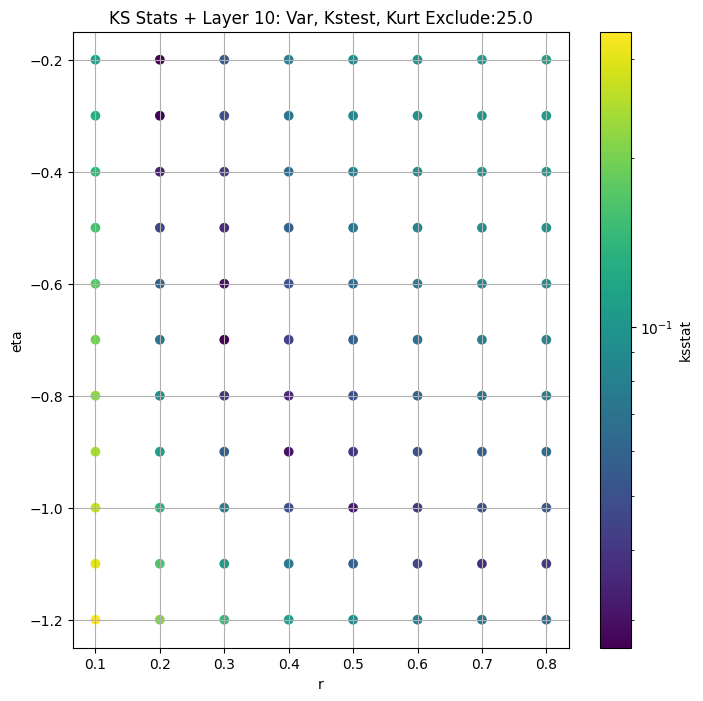

obs_var      var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                         
2      179850.660000  104860.610000  313803.400000    501.38205   36.681150   
3       48278.000000   29689.330000   75753.010000    352.49054   90.264786   
4       13505.898000    6427.192000   29259.107000   1066.34280  112.379980   
5        3324.956000    1098.146100   15512.162000   6607.17720   86.604630   
6         902.737550     217.958720    6909.141600  18939.14300   76.743290   
7         249.888720      58.955738    1795.422700  19071.88700   51.215460   
8          57.432180      22.249529     277.407500   8527.04700   61.023670   
9          14.412285       5.902647      62.396603   6442.50830   77.116610   
10          2.162876       0.811485       9.683873   7078.99500   80.460810   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        756.9423         9000.0             0.011226        0.2          0.2   
3        561.8886        36000.0             0.010555        0.1          1.6   
4       2700.4614       144000.0             0.006832        0.1          1.2   
5       7123.8887       576000.0             0.006039        0.1          1.7   
6       8727.6420      2304000.0             0.003903        0.1          2.3   
7       8606.3420      9216000.0             0.002910        0.1          2.6   
8       6916.6597     36864000.0             0.003380        0.1          2.2   
9       6425.3364    147456000.0             0.005910        0.1          2.2   
10      6695.1540    589824000.0             0.026810        0.3         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       6.076969e-01                    25.0        74067.336000   
3       4.795890e-12                   150.0        14752.112000   
4       3.266186e-12                   350.0         3012.707500   
5       1.261949e-13                   350.0          513.391970   
6       6.679078e-15                   250.0          125.501010   
7       1.159388e-15                   150.0           43.217403   
8       1.248305e-15                    75.0           18.465260   
9       2.988921e-16                   100.0            4.421290   
10      1.068965e-02                    25.0            0.852571   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.014297  
3                     0.007153  
4                     0.003578  
5                     0.001789  
6                     0.000895  
7                     0.000447  
8                     0.000224  
9                     0.000112  
10                    0.000056

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 879/879 [00:00<00:00, 1083.33it/s]


Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.022474696474615308, var: 48305.4921875


100%|██████████| 879/879 [00:00<00:00, 1255.91it/s]


Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.019587970764330165, var: 52651.171875


100%|██████████| 879/879 [00:00<00:00, 1239.88it/s]


Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.016732826987894578, var: 57748.68359375


100%|██████████| 879/879 [00:00<00:00, 1174.75it/s]


Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.013729395994492855, var: 64210.2421875


100%|██████████| 879/879 [00:00<00:00, 1238.89it/s]


Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.010460493316676311, var: 74067.3359375


100%|██████████| 879/879 [00:00<00:00, 1188.58it/s]


Finding Minimum after computing 879 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.018199507420882943, var: 179850.65625
Number of samples: 9000, Without approximation : 9000.0


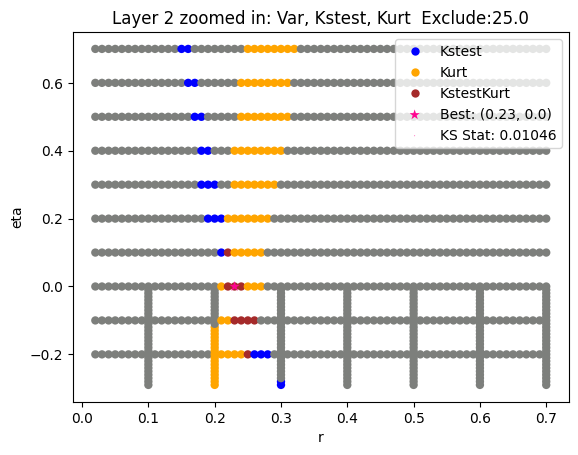

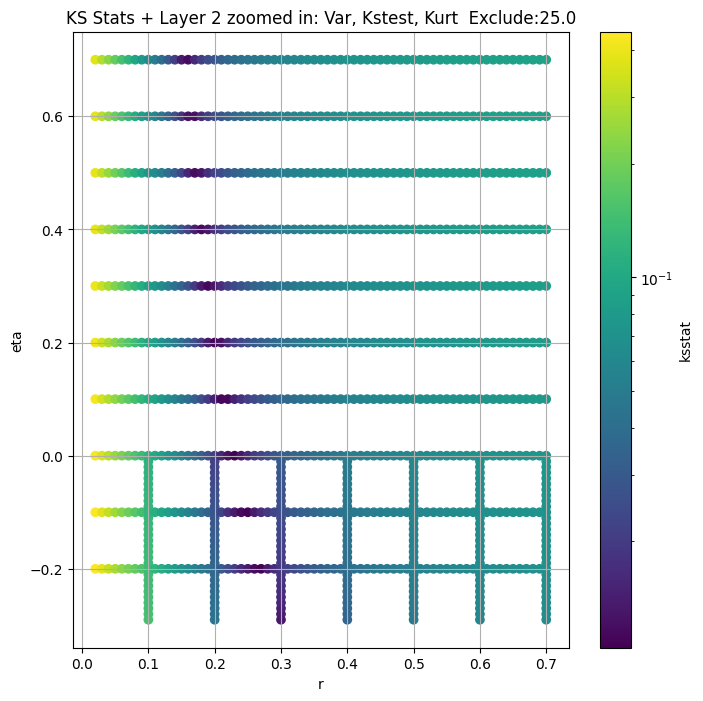

Layer 3


100%|██████████| 522/522 [00:01<00:00, 322.98it/s]


Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 100 = 250, ksstat: 0.01447152461272172, var: 12318.0419921875


100%|██████████| 522/522 [00:01<00:00, 377.22it/s]


Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 75 = 225, ksstat: 0.01378869811464345, var: 12829.607421875


100%|██████████| 522/522 [00:01<00:00, 377.85it/s]


Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 50 = 200, ksstat: 0.012780278031688241, var: 13399.0751953125


100%|██████████| 522/522 [00:01<00:00, 344.72it/s]


Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 25 = 175, ksstat: 0.011585289107966523, var: 14038.255859375


100%|██████████| 522/522 [00:01<00:00, 343.14it/s]


Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 0 = 150, ksstat: 0.010351867649363022, var: 14752.1123046875


100%|██████████| 522/522 [00:01<00:00, 337.74it/s]


Finding Minimum after computing 522 CDFs
layer 3, 150.0 + -25 = 125, ksstat: 0.009714978866768087, var: 15569.2109375


100%|██████████| 522/522 [00:01<00:00, 357.12it/s]


Finding Minimum after computing 522 CDFs
layer 3, 150.0 + -50 = 100, ksstat: 0.00950225222455725, var: 16572.76953125


100%|██████████| 522/522 [00:01<00:00, 357.66it/s]


Finding Minimum after computing 522 CDFs
layer 3, 150.0 + -75 = 75, ksstat: 0.010065881677922273, var: 17825.39453125


100%|██████████| 522/522 [00:01<00:00, 354.18it/s]


Finding Minimum after computing 522 CDFs
layer 3, 150.0 + -100 = 50, ksstat: 0.010724777891801596, var: 19635.3828125
Number of samples: 36000, Without approximation : 36000.0


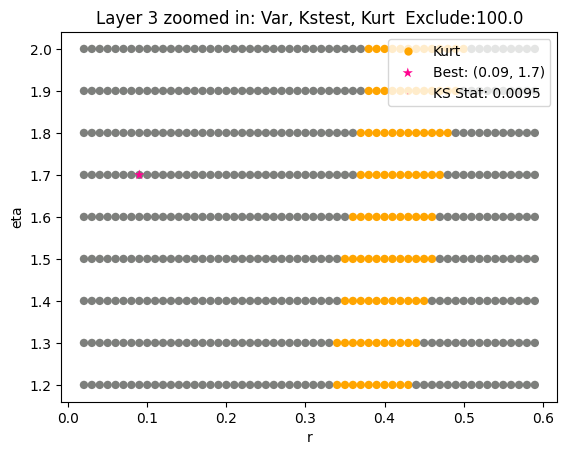

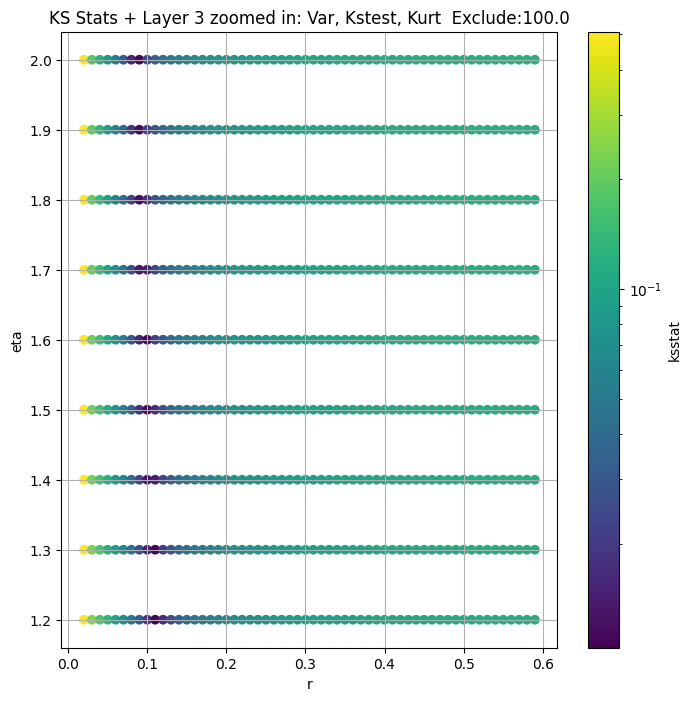

Layer 4


100%|██████████| 522/522 [00:04<00:00, 115.00it/s]


Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 100 = 450, ksstat: 0.007878527088664619, var: 2726.234130859375


100%|██████████| 522/522 [00:04<00:00, 112.53it/s]


Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 75 = 425, ksstat: 0.007467954421974779, var: 2791.064208984375


100%|██████████| 522/522 [00:04<00:00, 113.64it/s]


Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 50 = 400, ksstat: 0.007167807391477755, var: 2860.25390625


100%|██████████| 522/522 [00:04<00:00, 116.06it/s]


Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 25 = 375, ksstat: 0.007079746234409295, var: 2934.066650390625


100%|██████████| 522/522 [00:04<00:00, 116.55it/s]


Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 0 = 350, ksstat: 0.0068319376310044255, var: 3012.70751953125


100%|██████████| 522/522 [00:04<00:00, 117.46it/s]


Finding Minimum after computing 522 CDFs
layer 4, 350.0 + -25 = 325, ksstat: 0.007676864014943746, var: 3096.46630859375


100%|██████████| 522/522 [00:04<00:00, 113.89it/s]


Finding Minimum after computing 522 CDFs
layer 4, 350.0 + -50 = 300, ksstat: 0.0076086424479113735, var: 3187.02099609375


100%|██████████| 522/522 [00:04<00:00, 112.20it/s]


Finding Minimum after computing 522 CDFs
layer 4, 350.0 + -75 = 275, ksstat: 0.00846928661709731, var: 3286.474853515625


100%|██████████| 522/522 [00:04<00:00, 115.48it/s]


Finding Minimum after computing 522 CDFs
layer 4, 350.0 + -100 = 250, ksstat: 0.008399090045574042, var: 3397.178466796875
Number of samples: 100000, Without approximation : 144000.0


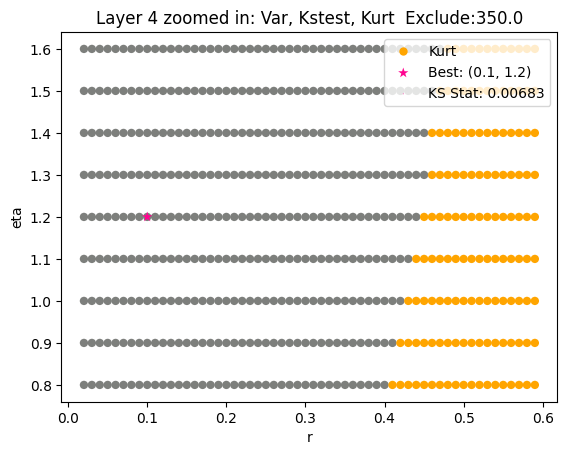

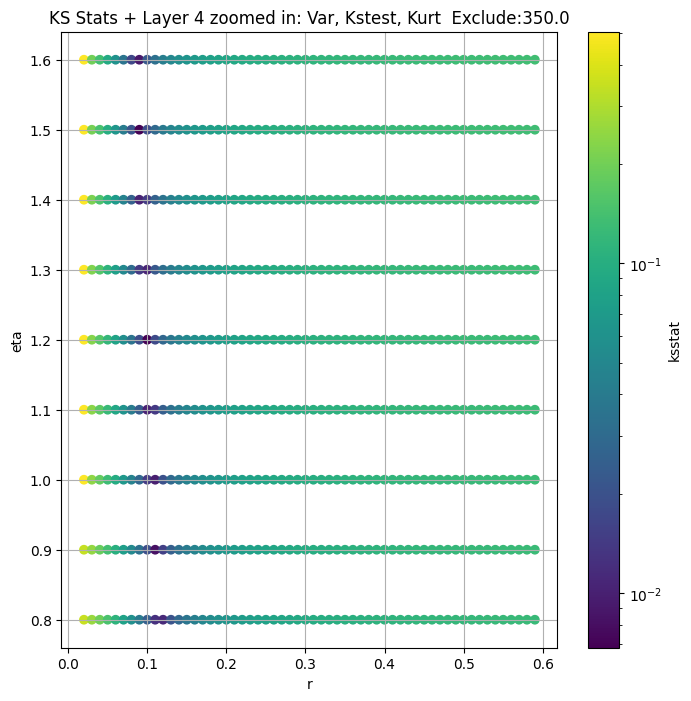

Layer 5


100%|██████████| 522/522 [00:04<00:00, 119.88it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 100 = 450, ksstat: 0.0073576158368166, var: 464.20013427734375


100%|██████████| 522/522 [00:04<00:00, 117.18it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 75 = 425, ksstat: 0.007007248987624282, var: 475.21337890625


100%|██████████| 522/522 [00:04<00:00, 116.31it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 50 = 400, ksstat: 0.0066628156010754, var: 487.0071716308594


100%|██████████| 522/522 [00:04<00:00, 118.98it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 25 = 375, ksstat: 0.0063293752926874, var: 499.6706237792969


100%|██████████| 522/522 [00:04<00:00, 114.92it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 0 = 350, ksstat: 0.006022030323383443, var: 513.3919677734375


100%|██████████| 522/522 [00:04<00:00, 113.79it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -25 = 325, ksstat: 0.005687912792637917, var: 528.4472045898438


100%|██████████| 522/522 [00:04<00:00, 115.91it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -50 = 300, ksstat: 0.005400568971195341, var: 545.0623168945312


100%|██████████| 522/522 [00:04<00:00, 120.66it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -75 = 275, ksstat: 0.006280943805758721, var: 563.4627075195312


100%|██████████| 522/522 [00:04<00:00, 118.57it/s]


Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -100 = 250, ksstat: 0.006939614807198152, var: 583.981201171875
Number of samples: 100000, Without approximation : 576000.0


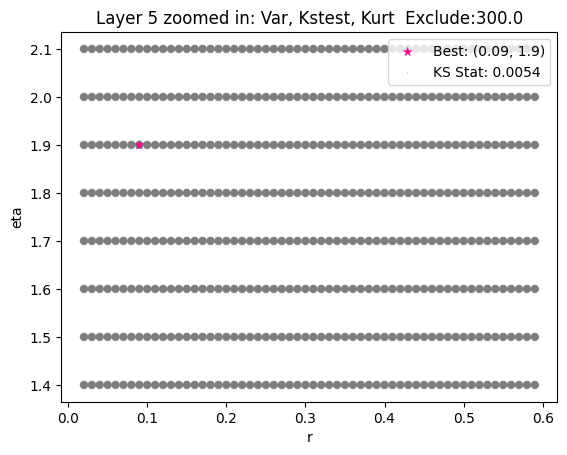

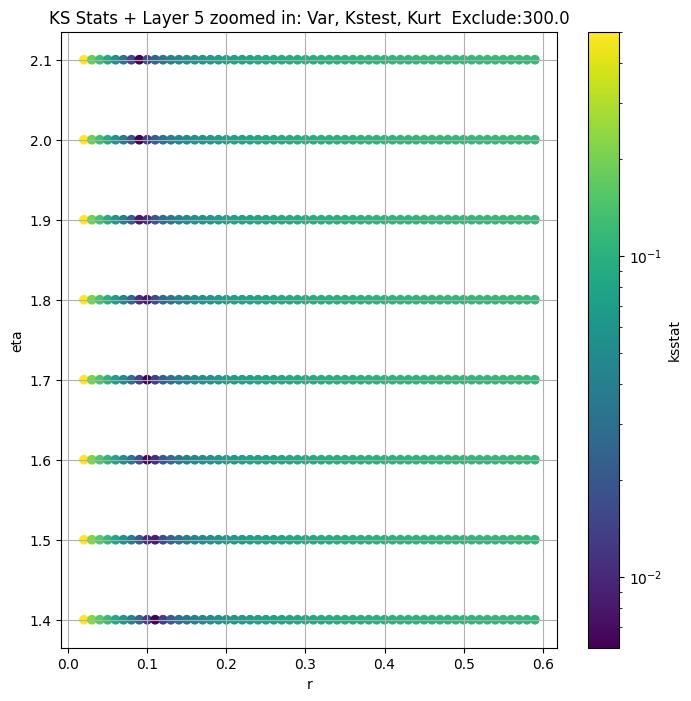

Layer 6


100%|██████████| 580/580 [00:04<00:00, 116.49it/s]


Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.0051866112989026325, var: 112.74742889404297


100%|██████████| 580/580 [00:05<00:00, 110.66it/s]


Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.004798387261456094, var: 115.50012969970703


100%|██████████| 580/580 [00:05<00:00, 110.29it/s]


Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.004485522958363797, var: 118.50956726074219


100%|██████████| 580/580 [00:04<00:00, 116.92it/s]


Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.0041706843946852645, var: 121.82398986816406


100%|██████████| 580/580 [00:05<00:00, 110.64it/s]


Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.0039034461095115436, var: 125.50100708007812


100%|██████████| 580/580 [00:04<00:00, 116.99it/s]


Finding Minimum after computing 580 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.003636437980372942, var: 129.64230346679688


100%|██████████| 580/580 [00:05<00:00, 112.26it/s]


Finding Minimum after computing 580 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.003949701762505503, var: 134.35391235351562


100%|██████████| 580/580 [00:05<00:00, 112.80it/s]


Finding Minimum after computing 580 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.004803580798073526, var: 139.8124237060547


100%|██████████| 580/580 [00:05<00:00, 114.26it/s]


Finding Minimum after computing 580 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.005603335075949428, var: 146.23716735839844
Number of samples: 100000, Without approximation : 2304000.0


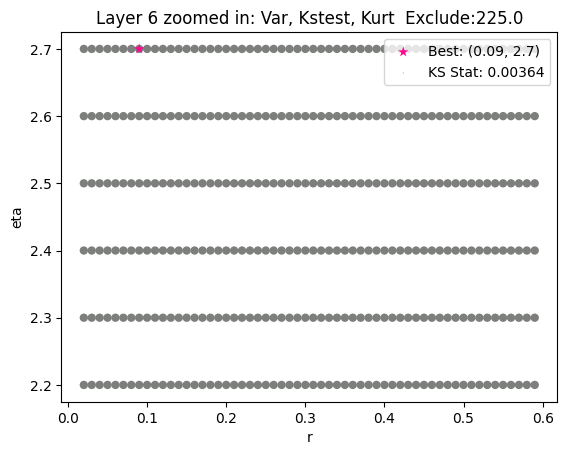

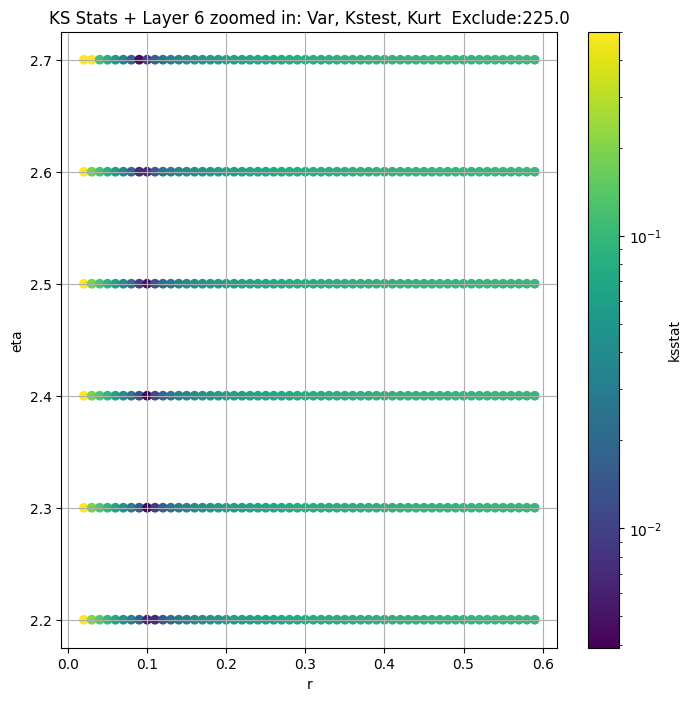

Layer 7


100%|██████████| 522/522 [00:04<00:00, 116.19it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.0036526040722553166, var: 38.34144973754883


100%|██████████| 522/522 [00:04<00:00, 110.83it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.0032993851585711997, var: 39.33442306518555


100%|██████████| 522/522 [00:04<00:00, 110.56it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.0029402893897471083, var: 40.45328903198242


100%|██████████| 522/522 [00:04<00:00, 109.95it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.0029737835803094192, var: 41.73221206665039


100%|██████████| 522/522 [00:04<00:00, 112.74it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.0029100000000000237, var: 43.217403411865234


100%|██████████| 522/522 [00:04<00:00, 115.29it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.0036422751586657753, var: 44.986793518066406


100%|██████████| 522/522 [00:04<00:00, 109.70it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.004451031557199392, var: 47.16108703613281


100%|██████████| 522/522 [00:04<00:00, 110.70it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.006172348360765911, var: 49.99258041381836


100%|██████████| 522/522 [00:04<00:00, 112.65it/s]


Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.00739842687479475, var: 54.04114532470703
Number of samples: 100000, Without approximation : 9216000.0


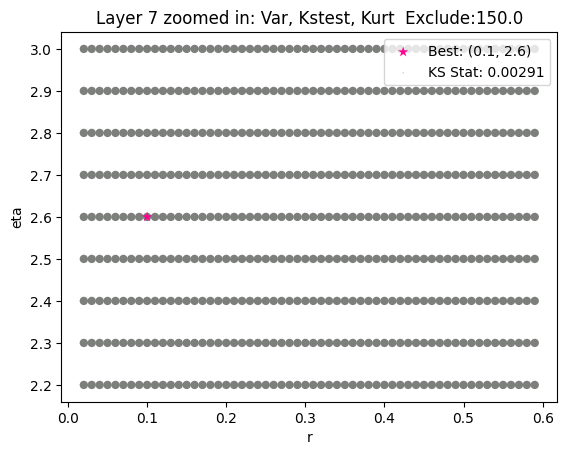

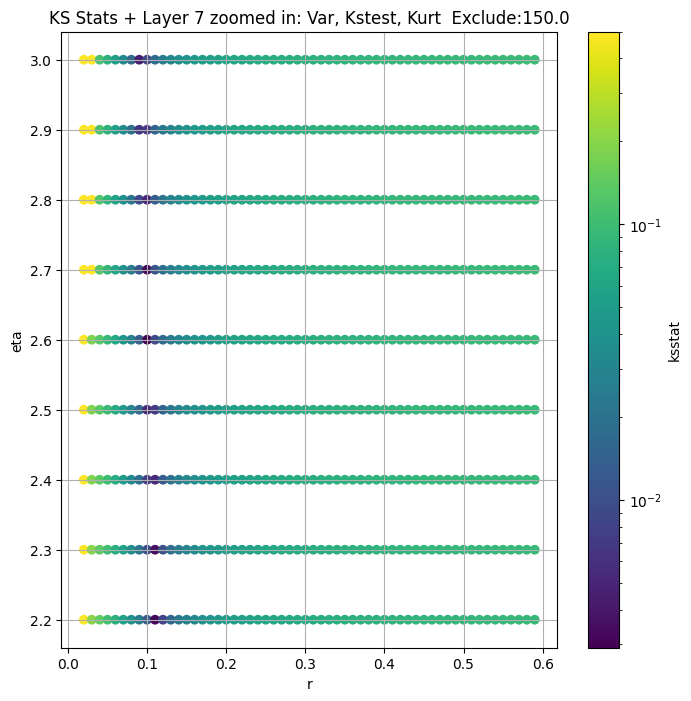

Layer 8


100%|██████████| 522/522 [00:04<00:00, 112.59it/s]


Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 100 = 175, ksstat: 0.0033799999999949426, var: 15.397746086120605


100%|██████████| 522/522 [00:04<00:00, 110.34it/s]


Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 75 = 150, ksstat: 0.0033799999999946095, var: 15.911528587341309


100%|██████████| 522/522 [00:04<00:00, 113.65it/s]


Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 50 = 125, ksstat: 0.0033799999999941654, var: 16.541711807250977


100%|██████████| 522/522 [00:04<00:00, 112.67it/s]


Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 25 = 100, ksstat: 0.0033800000000000496, var: 17.3497314453125


100%|██████████| 522/522 [00:04<00:00, 110.15it/s]


Finding Minimum after computing 522 CDFs
layer 8, 75.0 + 0 = 75, ksstat: 0.0033799999999997166, var: 18.465259552001953


100%|██████████| 522/522 [00:04<00:00, 109.55it/s]


Finding Minimum after computing 522 CDFs
layer 8, 75.0 + -25 = 50, ksstat: 0.004706598403414475, var: 20.164005279541016


100%|██████████| 522/522 [00:04<00:00, 111.86it/s]


Finding Minimum after computing 522 CDFs
layer 8, 75.0 + -50 = 25, ksstat: 0.008195829520461051, var: 23.21700096130371


100%|██████████| 522/522 [00:04<00:00, 113.82it/s]


Finding Minimum after computing 522 CDFs
layer 8, 75.0 + -75 = 0, ksstat: 0.024905332209889774, var: 57.43217849731445
Number of samples: 100000, Without approximation : 36864000.0


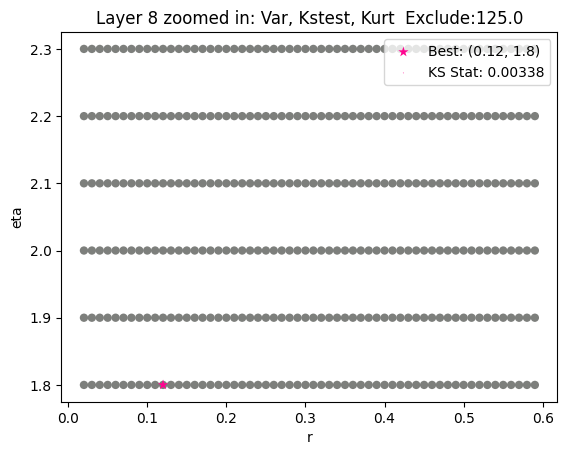

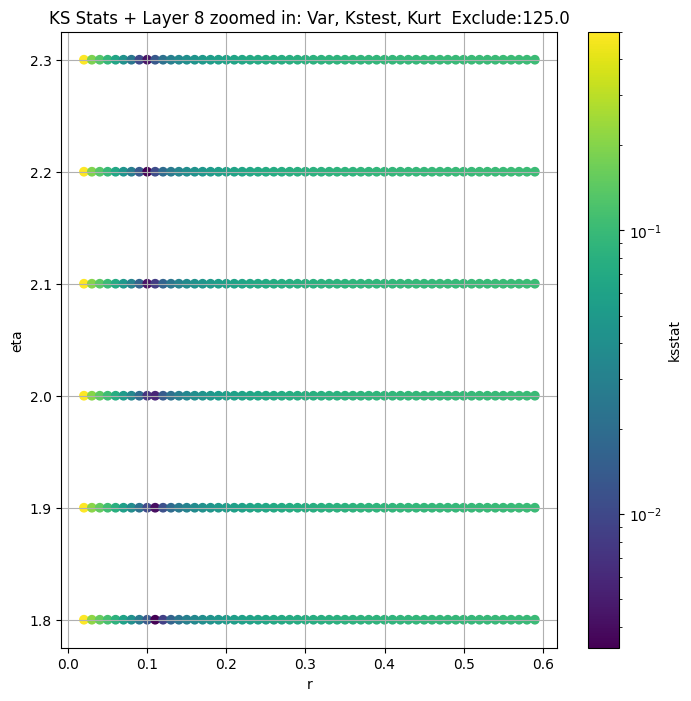

Layer 9


100%|██████████| 522/522 [00:04<00:00, 115.03it/s]


Finding Minimum after computing 522 CDFs
layer 9, 100.0 + 100 = 200, ksstat: 0.005909999999995308, var: 3.7602195739746094


100%|██████████| 522/522 [00:04<00:00, 116.69it/s]


Finding Minimum after computing 522 CDFs
layer 9, 100.0 + 75 = 175, ksstat: 0.005909999999995419, var: 3.8800461292266846


100%|██████████| 522/522 [00:04<00:00, 117.83it/s]


Finding Minimum after computing 522 CDFs
layer 9, 100.0 + 50 = 150, ksstat: 0.00590999999999553, var: 4.021963596343994


100%|██████████| 522/522 [00:04<00:00, 115.86it/s]


Finding Minimum after computing 522 CDFs
layer 9, 100.0 + 25 = 125, ksstat: 0.005909999999999971, var: 4.196280479431152


100%|██████████| 522/522 [00:04<00:00, 114.85it/s]


Finding Minimum after computing 522 CDFs
layer 9, 100.0 + 0 = 100, ksstat: 0.005909999999999749, var: 4.421289920806885


100%|██████████| 522/522 [00:04<00:00, 114.62it/s]


Finding Minimum after computing 522 CDFs
layer 9, 100.0 + -25 = 75, ksstat: 0.0062281690402816725, var: 4.735323429107666


100%|██████████| 522/522 [00:04<00:00, 115.03it/s]


Finding Minimum after computing 522 CDFs
layer 9, 100.0 + -50 = 50, ksstat: 0.007698695591165483, var: 5.230672836303711


100%|██████████| 522/522 [00:04<00:00, 111.61it/s]


Finding Minimum after computing 522 CDFs
layer 9, 100.0 + -75 = 25, ksstat: 0.010693314516328767, var: 6.166646957397461


100%|██████████| 522/522 [00:04<00:00, 114.44it/s]


Finding Minimum after computing 522 CDFs
layer 9, 100.0 + -100 = 0, ksstat: 0.025713534156407647, var: 14.412284851074219
Number of samples: 100000, Without approximation : 147456000.0


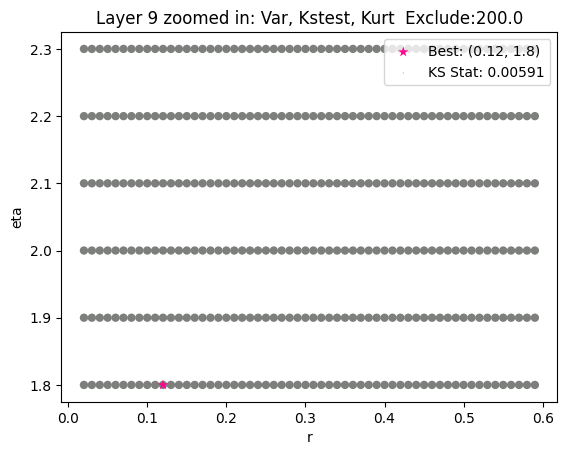

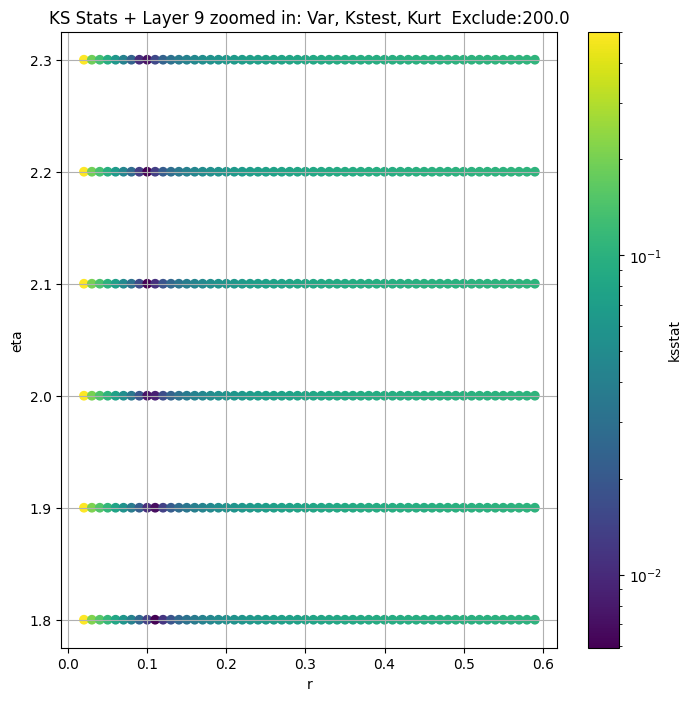

Layer 10


100%|██████████| 1410/1410 [00:12<00:00, 111.96it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 100 = 125, ksstat: 0.026809999999988454, var: 0.5733086466789246


100%|██████████| 1410/1410 [00:11<00:00, 119.12it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 75 = 100, ksstat: 0.02680999999998851, var: 0.6061050891876221


100%|██████████| 1410/1410 [00:11<00:00, 119.67it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 50 = 75, ksstat: 0.026809999999990564, var: 0.6513506770133972


100%|██████████| 1410/1410 [00:11<00:00, 120.81it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 25 = 50, ksstat: 0.02680999999999084, var: 0.7212808132171631


100%|██████████| 1410/1410 [00:11<00:00, 125.15it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + 0 = 25, ksstat: 0.02680999999999234, var: 0.8525710701942444


100%|██████████| 1410/1410 [00:11<00:00, 121.70it/s]


Finding Minimum after computing 1410 CDFs
layer 10, 25.0 + -25 = 0, ksstat: 0.03584783087905177, var: 2.1628763675689697
Number of samples: 100000, Without approximation : 589824000.0


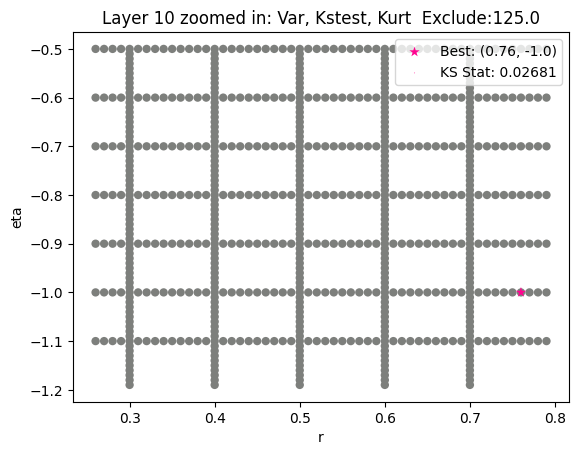

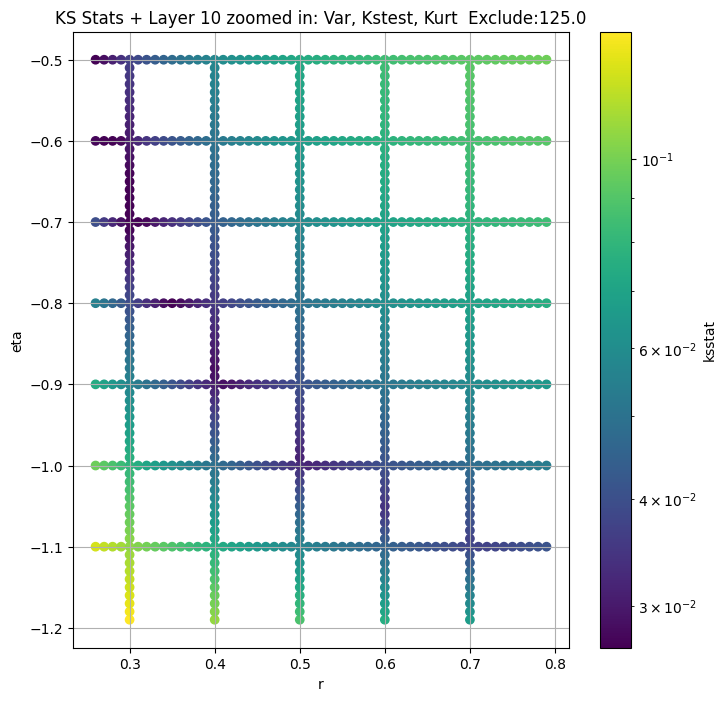

obs_var      var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                         
2      179850.660000  104860.610000  313803.400000    501.38205   36.681150   
3       48278.000000   29689.330000   75753.010000    352.49054   90.264786   
4       13505.898000    6427.192000   29259.107000   1066.34280  112.379980   
5        3324.956000    1098.146100   15512.162000   6607.17720   86.604630   
6         902.737550     217.958720    6909.141600  18939.14300   76.743290   
7         249.888720      58.955738    1795.422700  19071.88700   51.215460   
8          57.432180      22.249529     277.407500   8527.04700   61.023670   
9          14.412285       5.902647      62.396603   6442.50830   77.116610   
10          2.162876       0.811485       9.683873   7078.99500   80.460810   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        756.9423         9000.0             0.011226        0.2          0.2   
3        561.8886        36000.0             0.010555        0.1          1.6   
4       2700.4614       144000.0             0.006832        0.1          1.2   
5       7123.8887       576000.0             0.006039        0.1          1.7   
6       8727.6420      2304000.0             0.003903        0.1          2.3   
7       8606.3420      9216000.0             0.002910        0.1          2.6   
8       6916.6597     36864000.0             0.003380        0.1          2.2   
9       6425.3364    147456000.0             0.005910        0.1          2.2   
10      6695.1540    589824000.0             0.026810        0.3         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       6.076969e-01                    25.0        74067.335938   
3       4.795890e-12                   150.0        16572.769531   
4       3.266186e-12                   350.0         3012.707500   
5       1.261949e-13                   350.0          545.062317   
6       6.679078e-15                   250.0          129.642303   
7       1.159388e-15                   150.0           43.217403   
8       1.248305e-15                    75.0           16.541712   
9       2.988921e-16                   100.0            3.760220   
10      1.068965e-02                    25.0            0.573309   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.014297          0.010460    0.23       0.0   
3                     0.007153          0.009502    0.09       1.7   
4                     0.003578          0.006832    0.10       1.2   
5                     0.001789          0.005401    0.09       1.9   
6                     0.000895          0.003636    0.09       2.7   
7                     0.000447          0.002910    0.10       2.6   
8                     0.000224          0.003380    0.12       1.8   
9                     0.000112          0.005910    0.12       1.8   
10                    0.000056          0.026810    0.76      -1.0   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      8.296489e+00                 25.0        17085  
3      2.293902e-14                100.0        20250  
4      3.266186e-12                350.0        40500  
5      4.159330e-16                300.0        60750  
6      1.205381e-17                225.0       144000  
7      1.159388e-15                150.0       216000  
8      6.051204e-12                125.0       162000  
9      1.375544e-12                200.0        54000  
10     7.940592e-01                125.0         2530

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

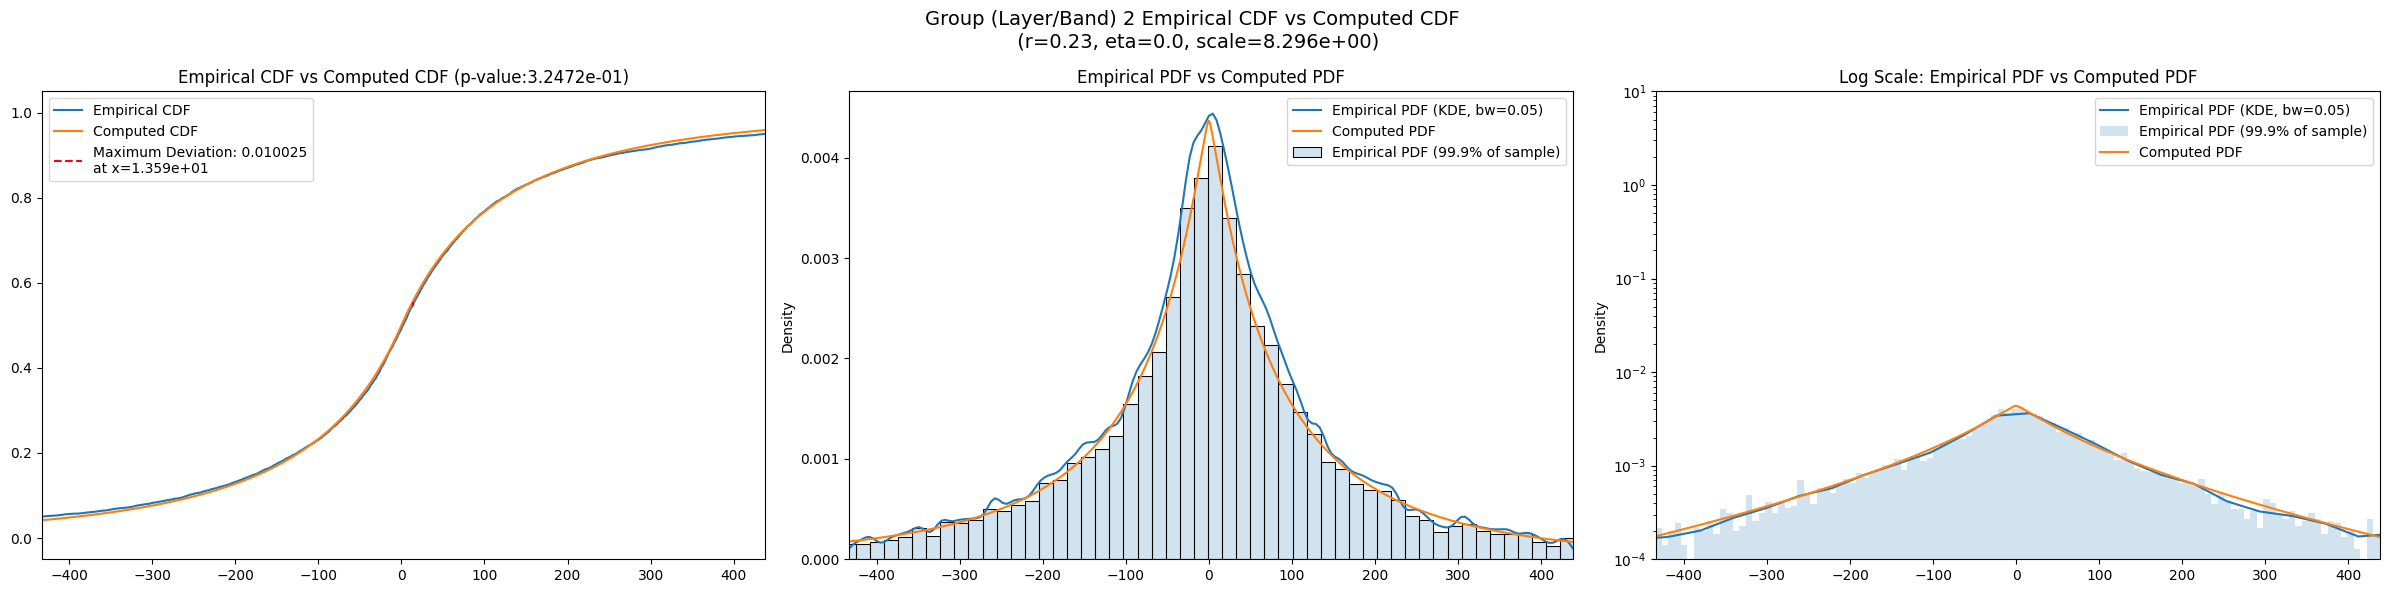

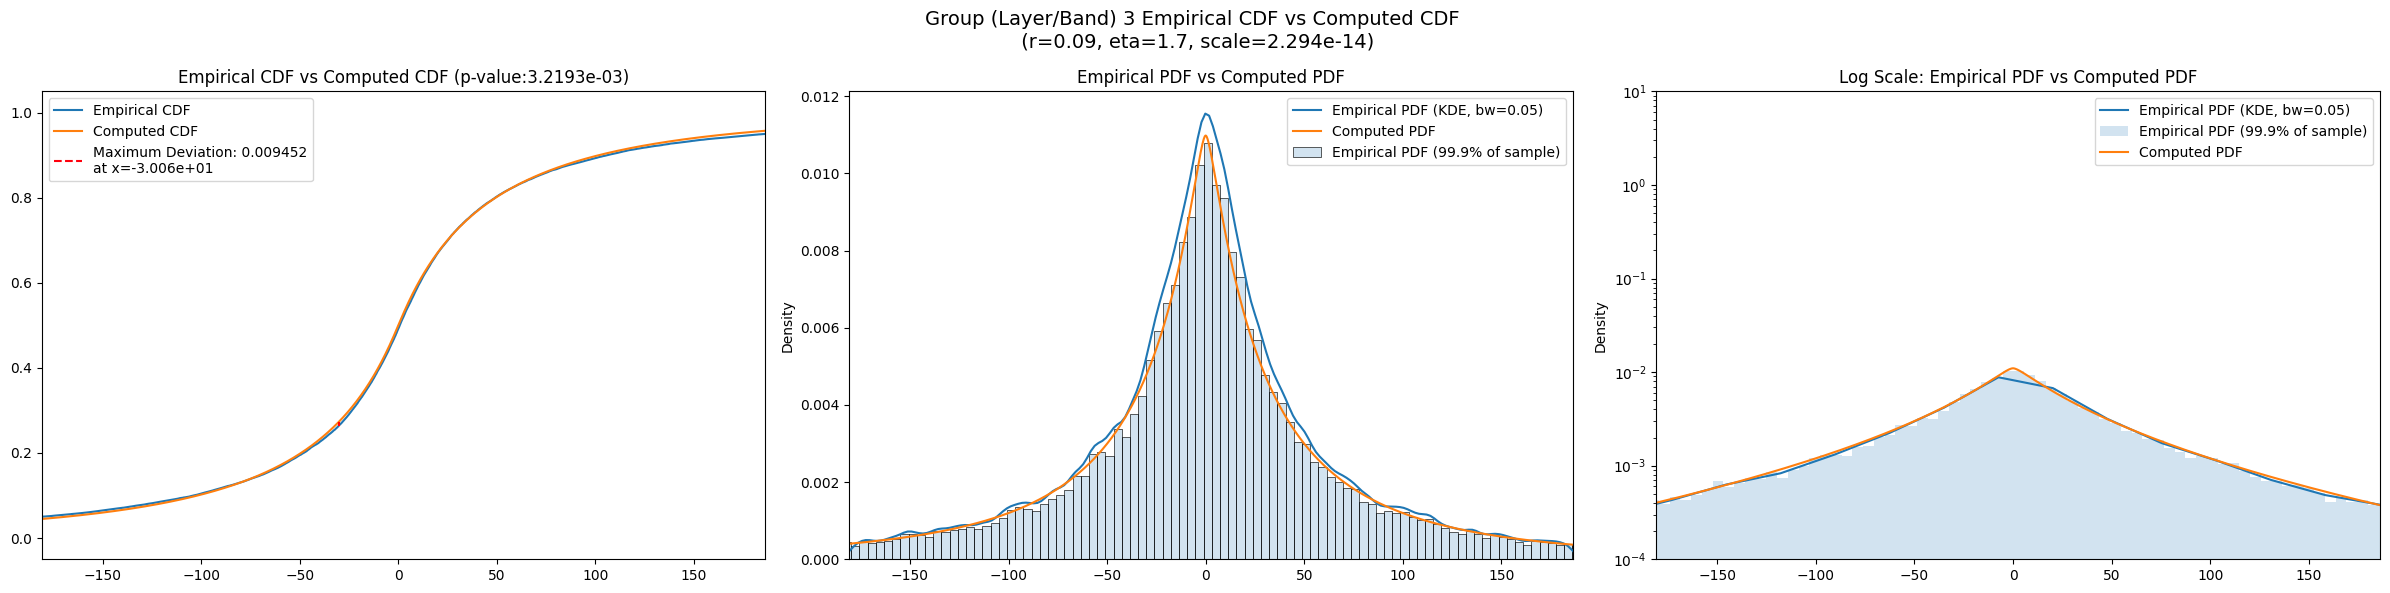

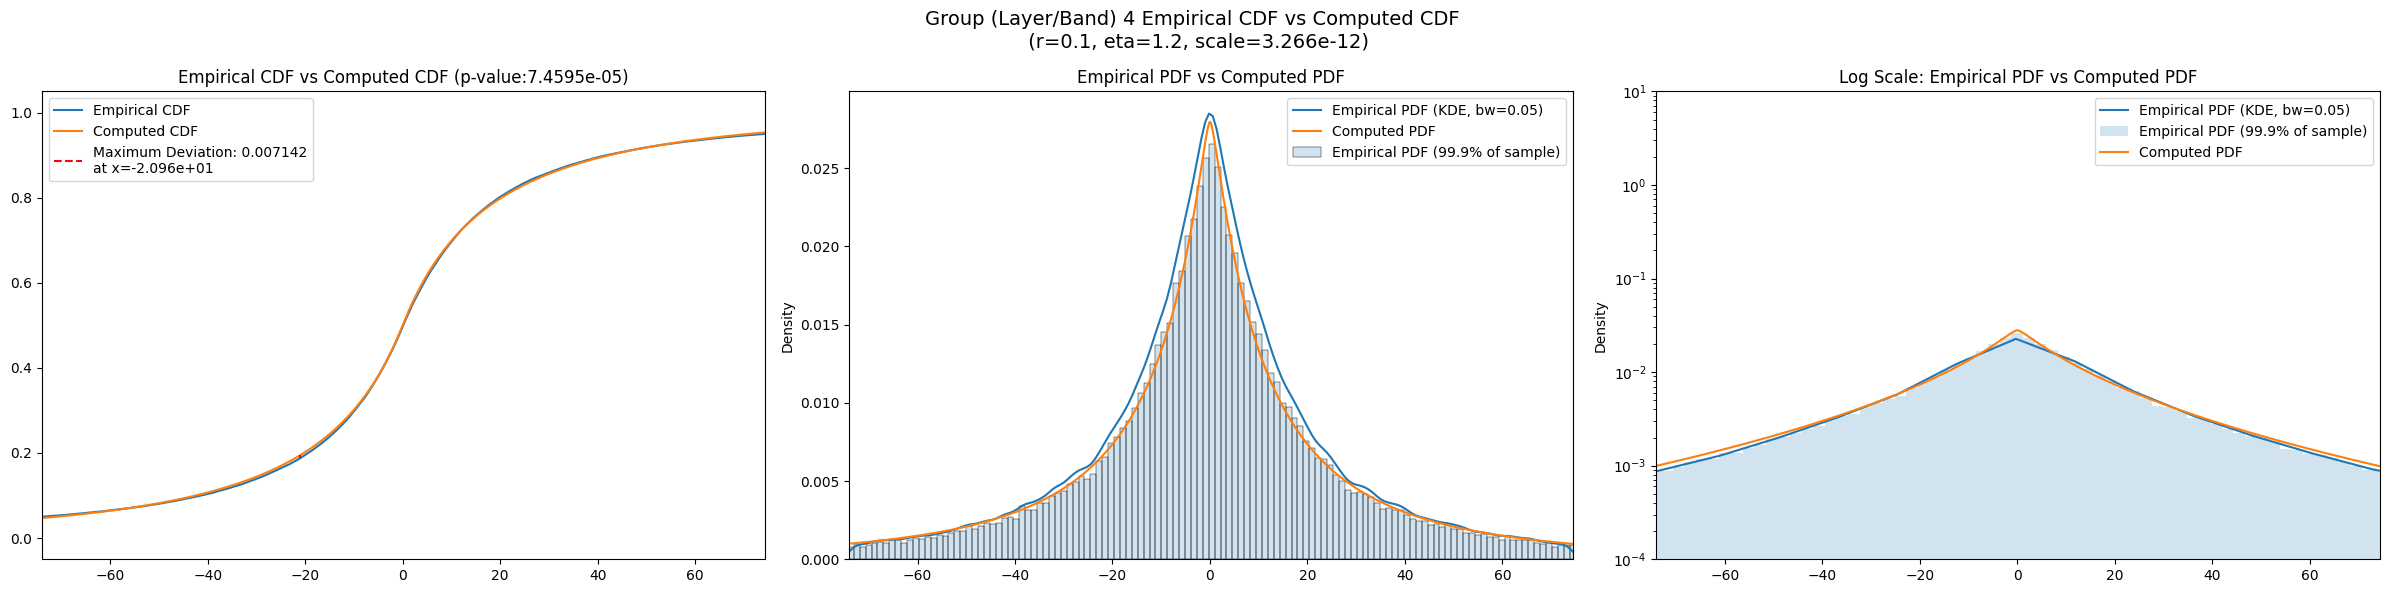

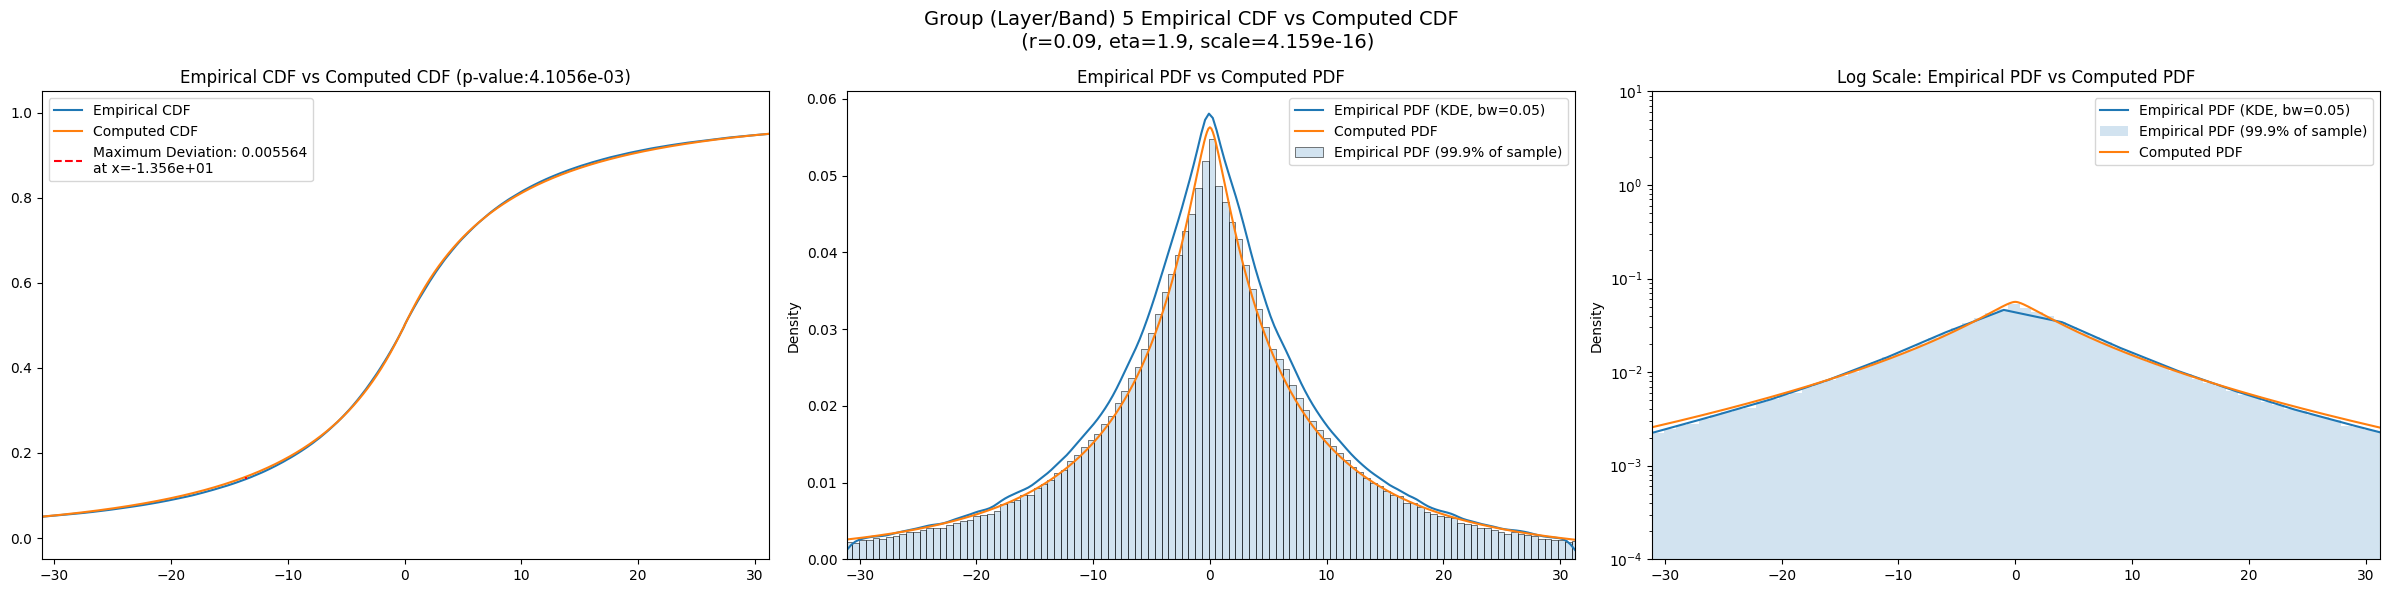

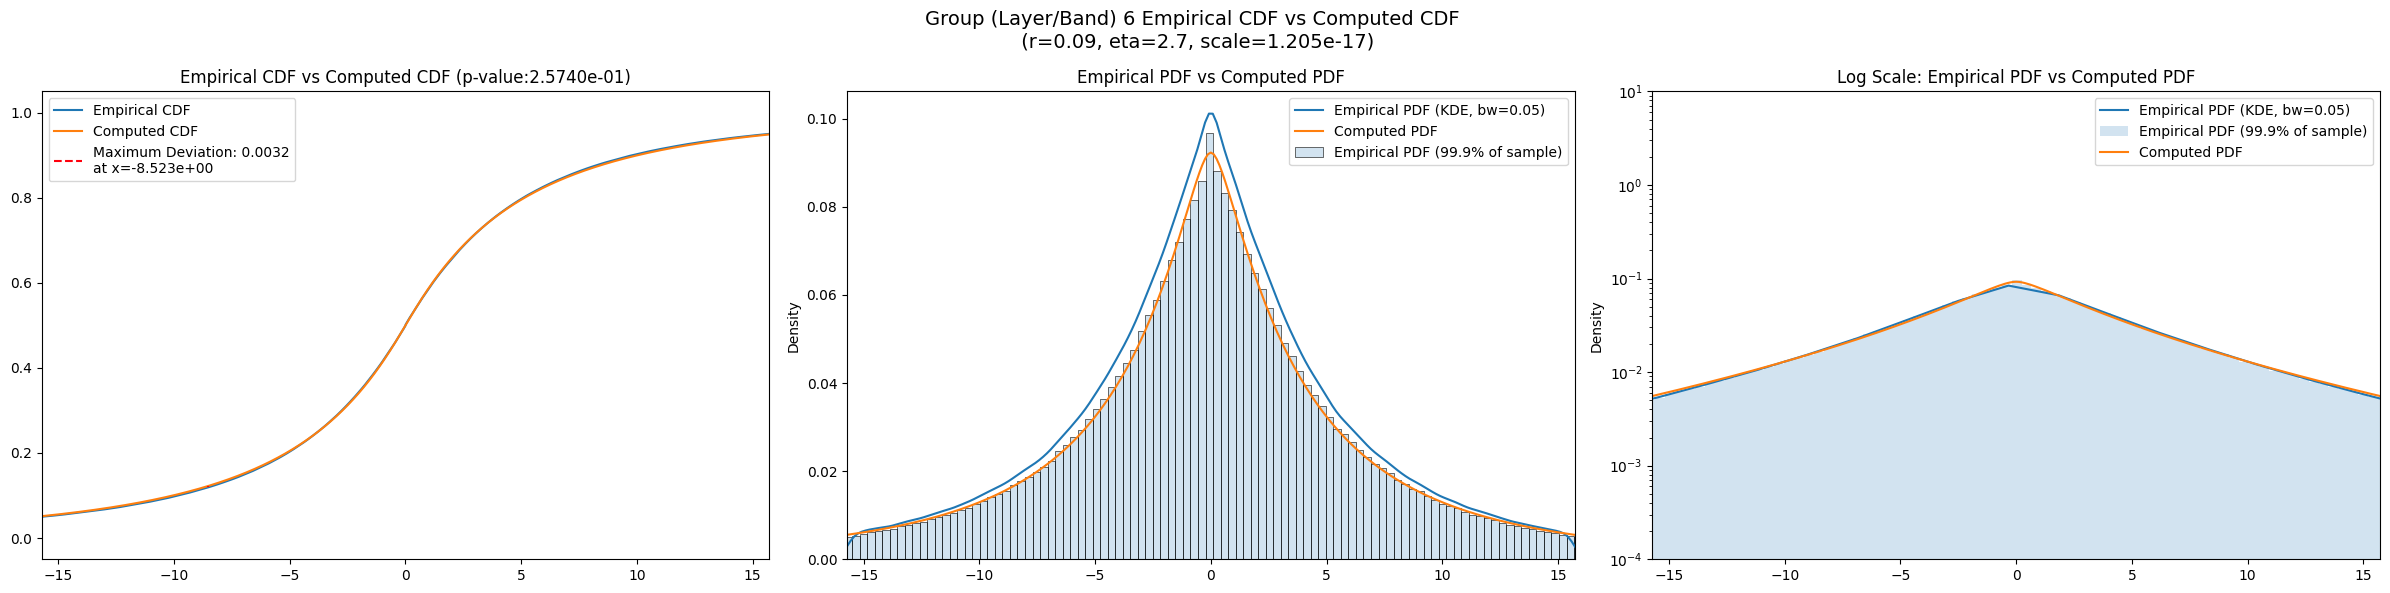

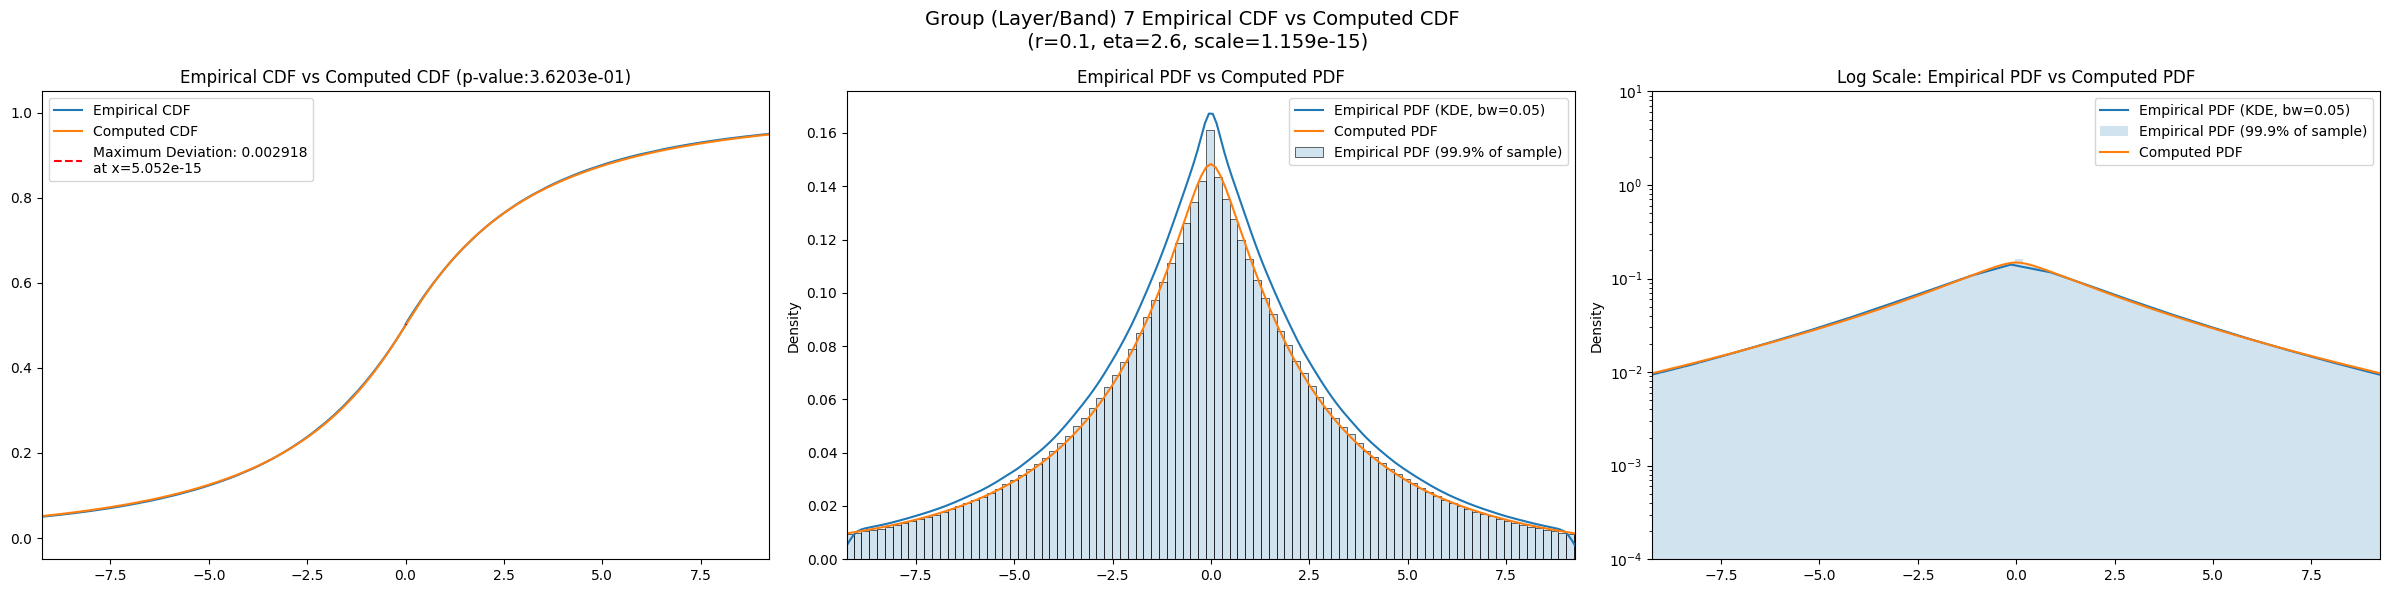

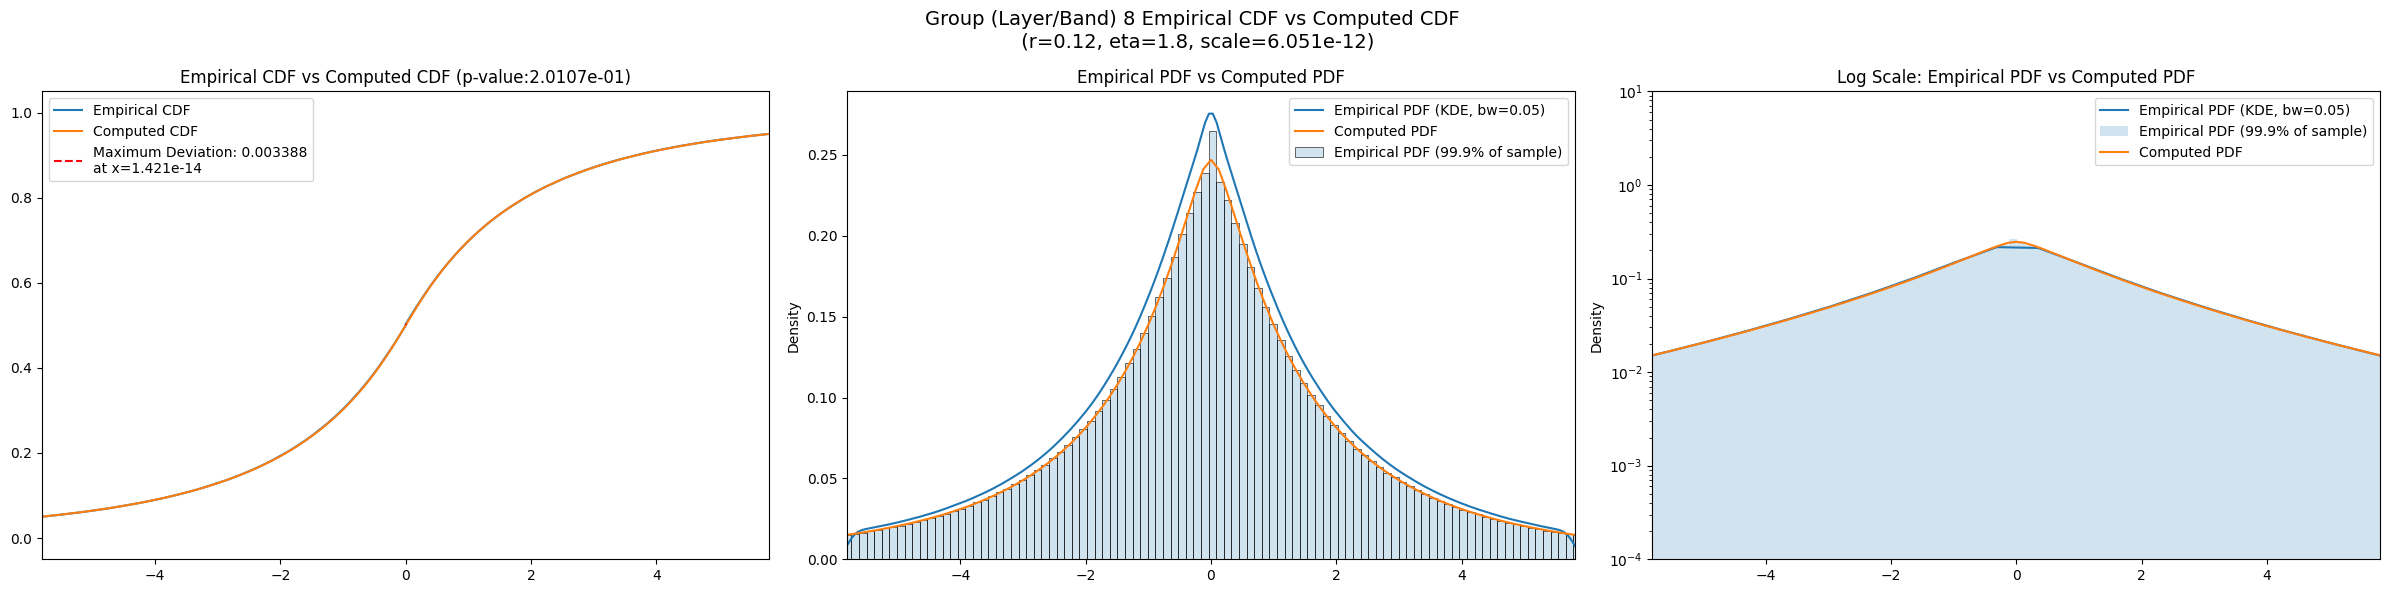

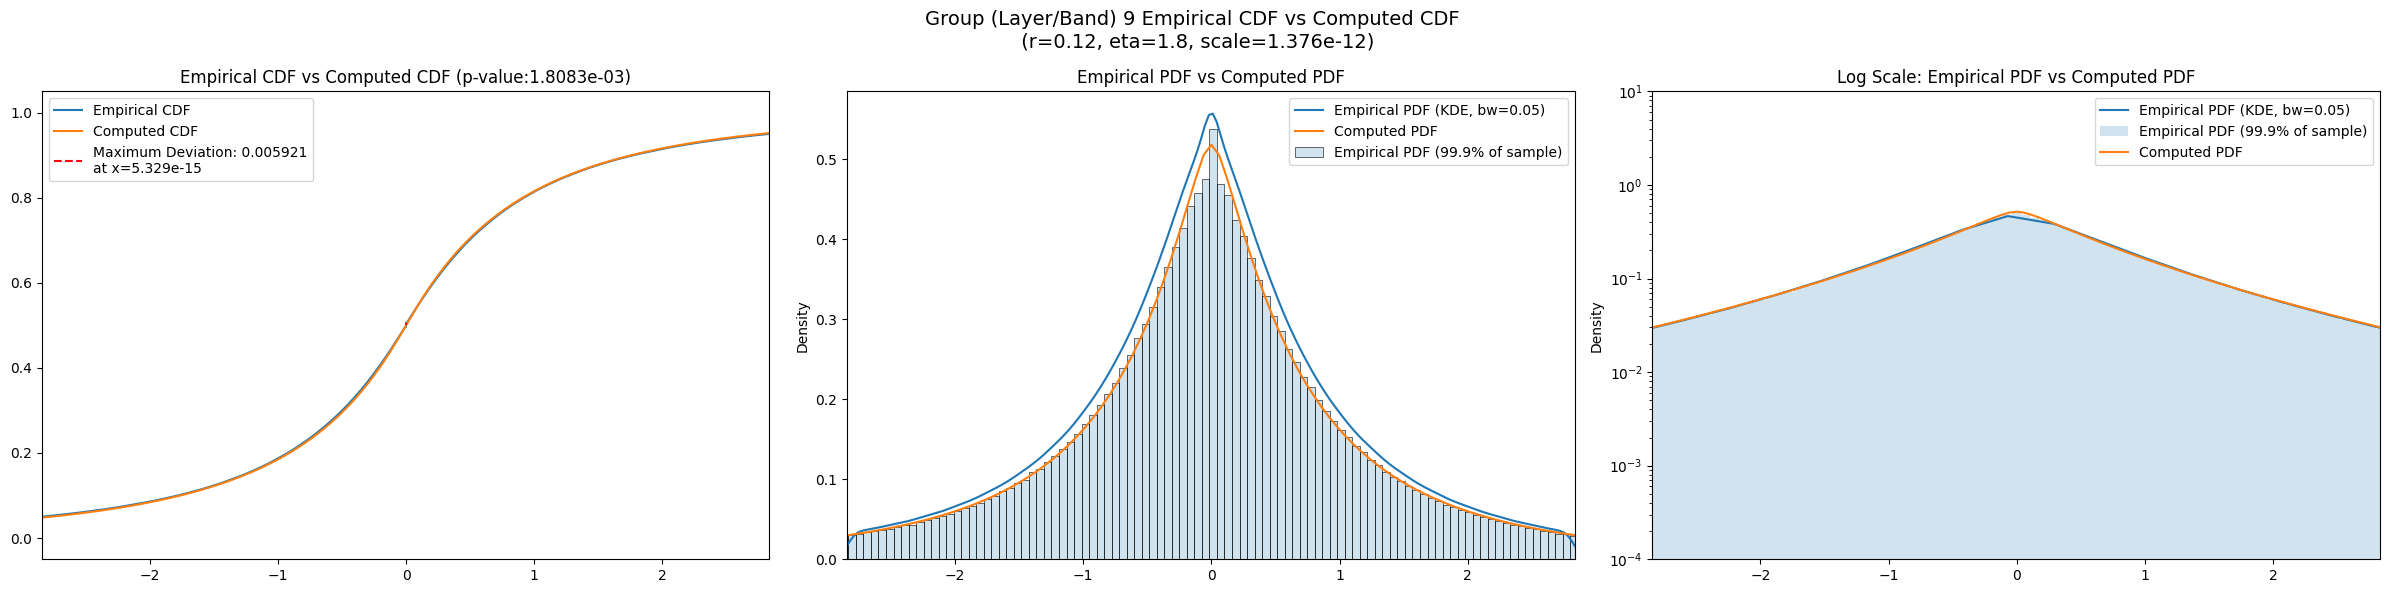

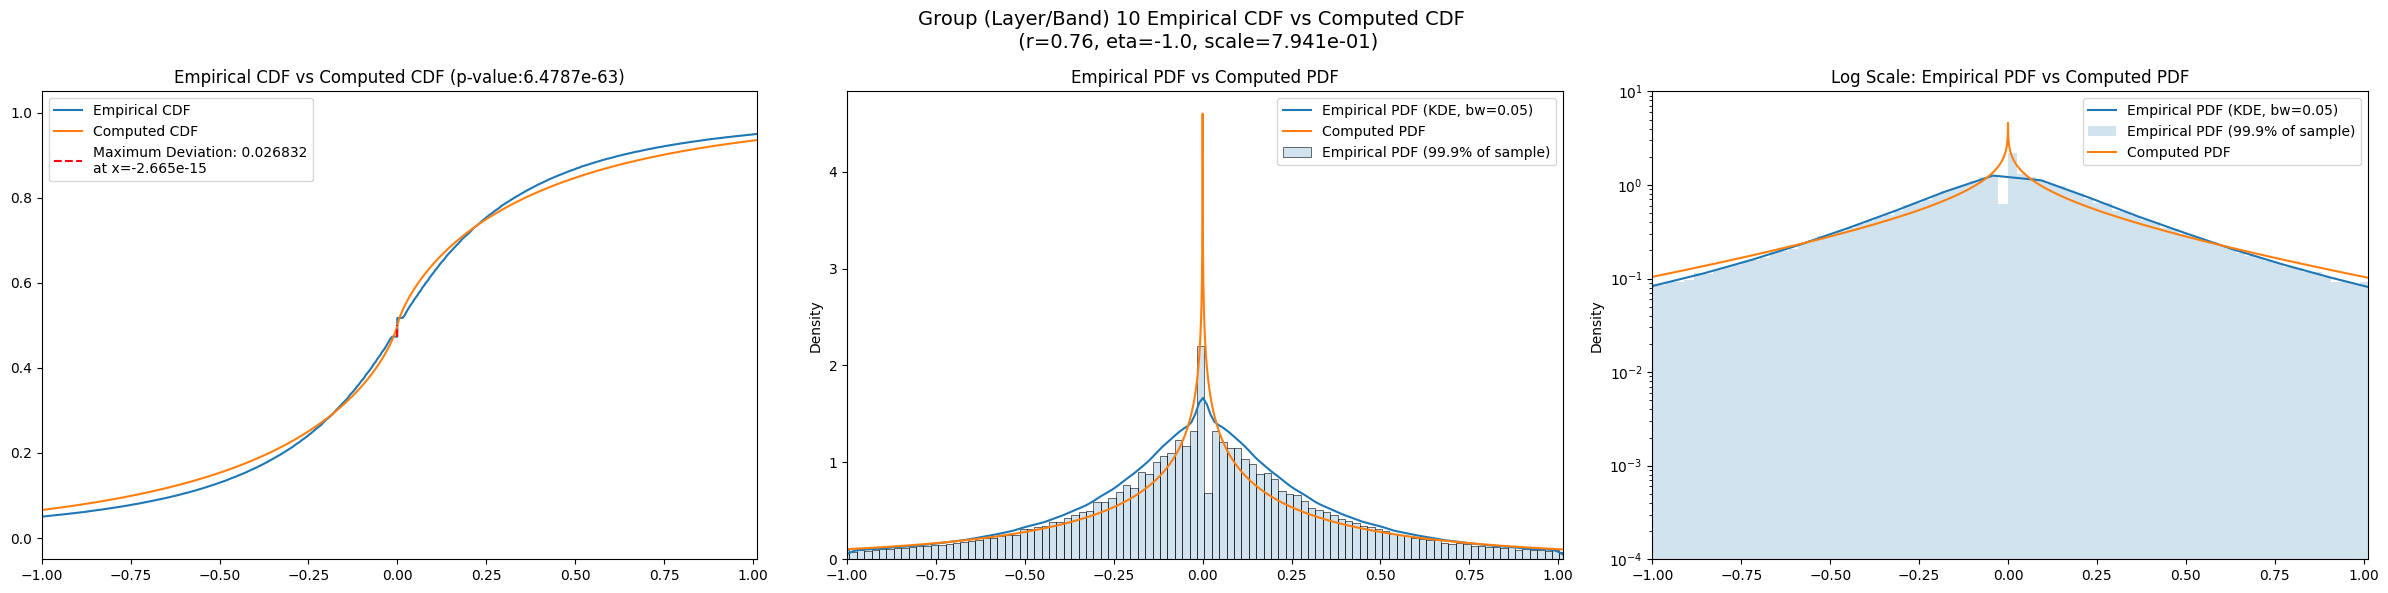

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                         
2      179850.660000  104860.610000  313803.400000    501.38205   36.681150   
3       48278.000000   29689.330000   75753.010000    352.49054   90.264786   
4       13505.898000    6427.192000   29259.107000   1066.34280  112.379980   
5        3324.956000    1098.146100   15512.162000   6607.17720   86.604630   
6         902.737550     217.958720    6909.141600  18939.14300   76.743290   
7         249.888720      58.955738    1795.422700  19071.88700   51.215460   
8          57.432180      22.249529     277.407500   8527.04700   61.023670   
9          14.412285       5.902647      62.396603   6442.50830   77.116610   
10          2.162876       0.811485       9.683873   7078.99500   80.460810   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        756.9423         9000.0             0.011226        0.2          0.2   
3        561.8886        36000.0             0.010555        0.1          1.6   
4       2700.4614       144000.0             0.006832        0.1          1.2   
5       7123.8887       576000.0             0.006039        0.1          1.7   
6       8727.6420      2304000.0             0.003903        0.1          2.3   
7       8606.3420      9216000.0             0.002910        0.1          2.6   
8       6916.6597     36864000.0             0.003380        0.1          2.2   
9       6425.3364    147456000.0             0.005910        0.1          2.2   
10      6695.1540    589824000.0             0.026810        0.3         -0.7   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      161.315000              0.054731          7.138960e-24   
3      ...       64.387600              0.057965         1.396570e-105   
4      ...       26.435600              0.054962          0.000000e+00   
5      ...       12.264400              0.048018          0.000000e+00   
6      ...        6.732320              0.041889          0.000000e+00   
7      ...        4.053460              0.040115          0.000000e+00   
8      ...        2.495400              0.042227          0.000000e+00   
9      ...        1.214770              0.042277          0.000000e+00   
10     ...        0.426317              0.043705          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         142.176000             0.028658         7.442110e-07  111.133000   
3          57.121400             0.031868         3.385140e-32   45.020700   
4          23.537300             0.029317        5.892970e-108   18.353100   
5          10.938100             0.022895        1.012760e-262    8.580430   
6           5.972800             0.016282         0.000000e+00    4.733350   
7           3.588460             0.013913         0.000000e+00    2.852480   
8           2.200810             0.015294         0.000000e+00    1.757550   
9           1.073640             0.015960         0.000000e+00    0.855090   
10          0.337135             0.026810         0.000000e+00    0.302689   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.028436   9.344680e-07          2.763515e-01  
3           0.029345   2.298580e-27          2.984391e-03  
4           0.026335   3.414980e-87          2.890638e-06  
5           0.018531  3.032770e-172          5.097341e-15  
6           0.013603   0.000000e+00          6.860618e-27  
7           0.013148   0.000000e+00          3.264068e-68  
8           0.015197   0.000000e+00          0.000000e+00  
9           0.014041   0.000000e+00  

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.011226                 0.014297          0.010460   
3                 0.010555                 0.007153          0.009502   
4                 0.006832                 0.003578          0.006832   
5                 0.006039                 0.001789          0.005401   
6                 0.003903                 0.000895          0.003636   
7                 0.002910                 0.000447          0.002910   
8                 0.003380                 0.000224          0.003380   
9                 0.005910                 0.000112          0.005910   
10                0.026810                 0.000056          0.026810   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.054731             0.028658       0.028436  
3                  0.057965             0.031868       0.029345  
4                  0.054962             0.029317       0.026335  
5                  0.048018             0.022895       0.018531  
6                  0.041889             0.016282       0.013603  
7                  0.040115             0.013913       0.013148  
8                  0.042227             0.015294       0.015197  
9                  0.042277             0.015960       0.014041  
10                 0.043705             0.026810       0.026810

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            74067.335938          0.010460    0.23       0.0  8.296489e+00   
3            16572.769531          0.009502    0.09       1.7  2.293902e-14   
4             3012.707500          0.006832    0.10       1.2  3.266186e-12   
5              545.062317          0.005401    0.09       1.9  4.159330e-16   
6              129.642303          0.003636    0.09       2.7  1.205381e-17   
7               43.217403          0.002910    0.10       2.6  1.159388e-15   
8               16.541712          0.003380    0.12       1.8  6.051204e-12   
9                3.760220          0.005910    0.12       1.8  1.375544e-12   
10               0.573309          0.026810    0.76      -1.0  7.940592e-01   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                    100.0  
4                    350.0  
5                    300.0  
6                    225.0  
7                    150.0  
8                    125.0  
9                    200.0  
10                   125.0

In [21]:
eng.quit()